In [1]:
import itertools
import os
from pathlib import Path
import subprocess
import sys

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *
from math import log,inf,exp
import math

from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
import logomaker as lm

from matplotlib_venn import venn2
from dna_features_viewer import GraphicFeature, GraphicRecord

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
origin = (3925743, 3925975)
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon_bitomekb.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [4]:
import ast
im_info = pd.read_csv('../data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )

# ArcA

In [5]:
arca_tfbs = mg1655.tfbs_table[mg1655.tfbs_table['tf']=='ArcA']
keep_inds=[]
for i in range(len(arca_tfbs['left'])):
    if arca_tfbs['left'][i] !=0 and arca_tfbs['right'][i] !=0:
        keep_inds.append(i)
arca_tfbs = arca_tfbs.iloc[keep_inds]
arca_tfbs = arca_tfbs.reset_index()

In [6]:
arca_tfbs.head()

,locus_tag,left,right,mode,final_state,tf,strand
0,ECK120011372,656416,656430,activator,ArcA-Phosphorylated,ArcA,NaN
1,ECK120011435,3128180,3128194,repressor,ArcA-Phosphorylated,ArcA,NaN
2,ECK120011512,3146413,3146427,repressor,ArcA-Phosphorylated,ArcA,NaN
3,ECK120011880,866524,866538,activator,ArcA-Phosphorylated,ArcA,NaN
4,ECK120011964,4360278,4360292,repressor,ArcA-Phosphorylated,ArcA,NaN


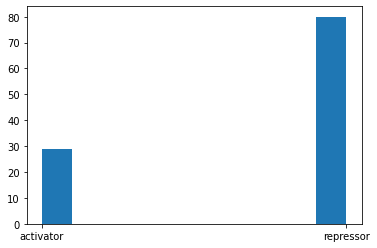

In [7]:
plt.hist( arca_tfbs['mode']);

In [8]:
tu_ids = []
tss_list = []
op_name_list = []
op_id_list = []
strand_list = []
for i in range( len(arca_tfbs['left']) ):
    tfbs_left = arca_tfbs['left'][i]
    tfbs_right = arca_tfbs['right'][i]
    temp = mg1655.features_in_range( tfbs_left, tfbs_right  )
    temp = temp[temp['type']=='operon']
    strand_list.append( list(temp['strand'])[0]  )
    op_name_list.append( list(temp['name'])[0] )
    op_id_list.append( list(temp.index)[0] )
    
    op_left = list(temp['left'])[0]
    op_right = list(temp['right'])[0]
    temp = mg1655.features_in_range( op_left, op_right  )
    temp = temp[temp['type']=='tu']
    distance = []
    for tss in temp['tss']:
        dist = tss - (tfbs_left + tfbs_right)/2
        distance.append( abs(dist ) )
        
    min_index = distance.index( min(distance) )
    tu_ids.append(  list(temp.index)[min_index] )
    tss_list.append(  list(temp['tss'])[min_index] )
    
arca_tfbs['tu_id'] = tu_ids
arca_tfbs['strand'] = strand_list
arca_tfbs['tss'] = tss_list
arca_tfbs['operon_id'] = op_id_list
arca_tfbs['operon_name'] = op_name_list
arca_tfbs = arca_tfbs.dropna()
arca_tfbs = arca_tfbs.reset_index()
arca_tfbs = arca_tfbs.drop(columns=['index'])

(-230.0, 200.0)

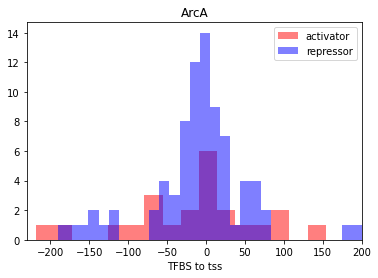

In [9]:
tssTotfbs = {'A':[],'R':[]}
for i in range( len(arca_tfbs['left']) ):
    tfbs_left = arca_tfbs['left'][i]
    tfbs_right = arca_tfbs['right'][i]
    mid = (tfbs_left + tfbs_right)/2
    tss = arca_tfbs['tss'][i]
    if arca_tfbs['mode'][i] == 'activator':
        tssTotfbs['A'].append(  mid - tss )
    else:
        tssTotfbs['R'].append(  mid - tss )
        
plt.hist( tssTotfbs['A'],bins=50,alpha=0.5, color='red', label='activator')
plt.hist( tssTotfbs['R'],bins=30,alpha=0.5, color = 'blue',label = 'repressor')
plt.legend(loc='upper right')
plt.xlabel('TFBS to tss')
plt.title('ArcA')
plt.xlim([-230,200])

## - DR motifs

In [10]:
ArcA_2DR = []
ArcA_3DR = []
ArcA_4DR = []

ArcA_DR = []
ffile = open('../data/ArcA_DR.txt', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    if line[0] == '>':
        continue
    seq = line.strip()
    if len(seq) >40:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_DR.append( seq[22:32])
        ArcA_DR.append( seq[33:43])
        ArcA_4DR.append( seq)
    elif len(seq) > 30:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_DR.append( seq[22:32])
        ArcA_3DR.append( seq )
    else:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_2DR.append( seq )
        ArcA_2DR = list(filter(lambda a: len(a) != 0, ArcA_2DR))
        
ArcA_DR = list(filter(lambda a: len(a) == 10, ArcA_DR))

In [11]:
cm = {1:lm.alignment_to_matrix(ArcA_DR),2:lm.alignment_to_matrix(ArcA_2DR),
      3:lm.alignment_to_matrix(ArcA_3DR),4:lm.alignment_to_matrix(ArcA_4DR)}

PWM_DR = {}
for k in cm.keys():
    temp_pwm = []
    temp_cm = cm[k]
    for i in range(len(temp_cm['A']) ):
        SUM = 4+ temp_cm['A'][i]+temp_cm['C'][i]+temp_cm['T'][i]+temp_cm['G'][i]

        temp_pwm.append( {'A':log( (temp_cm['A'][i]+1)/SUM ),
                      'C':log( (temp_cm['C'][i]+1)/SUM ),
                      'G':log( (temp_cm['G'][i]+1)/SUM ),
                      'T':log( (temp_cm['T'][i]+1)/SUM  )   })
    PWM_DR[k] = temp_pwm

In [12]:
def match1DR( tss, strand , bitome_obj, N_UPSTREAM, N_DOWNSTREAM, M, DR_num ):
     # N is the number of DRs to match
    if strand == 1:
        
        locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
        bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:

        locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
        bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
    DR_scores = []
    sequence = seq_loc.extract(bitome_obj.sequence)
    for i in range(len(sequence) - len(M) + 1):
        subbox = sequence[i:i+ len(M) ]
        DR_scores.append( score_motif(subbox,M) )
        
    max_score =  max( DR_scores )
    ind = DR_scores.index( max_score )
    mid = ind + len(M)/2  
    distTSS = abs(N_UPSTREAM - mid )
    if mid < N_UPSTREAM:
        up = 1
    else:
        up = 0
    result = {}
    result[str(DR_num)+'DR_score'] = max_score
    result[str(DR_num)+'DR_distTSS'] = distTSS
    result[str(DR_num)+'DR_upstream'] = up
    result['seq'] = str(sequence)
    
    
    return result

In [13]:
N_UPSTREAM  = 100
N_DOWNSTREAM = 100
DR_data = []
for i in range( len(arca_tfbs['left']) ):
    data = {}
    data['tu_id'] = arca_tfbs['tu_id'][i]
    tss = arca_tfbs['tss'][i]
    strand = arca_tfbs['strand'][i]
    for k in PWM_DR.keys():
            data.update(  match1DR( int(tss) ,  int(strand) , mg1655 ,
                                   N_UPSTREAM, N_DOWNSTREAM, PWM_DR[k], int(k)) )
            
    DR_data.append( data )
DR_table = pd.DataFrame( DR_data )

In [14]:
cutoff = { 2: -23.3628,3: -38.44,4:-52.94}

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


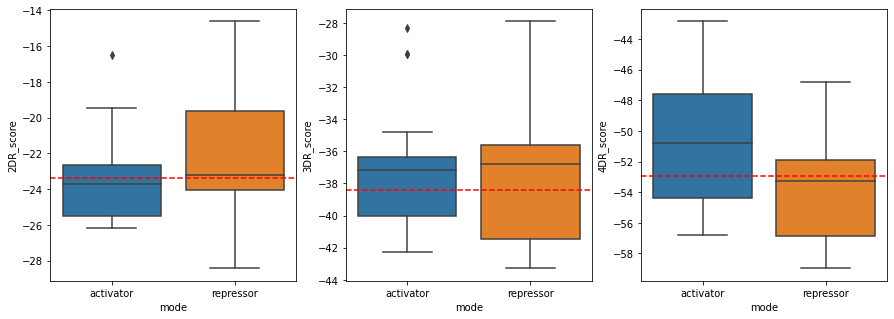

In [39]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(2,5):
    sns.boxplot( arca_tfbs['mode'],DR_table[str(i)+'DR_score'], ax = axs[i-2] )
    axs[i-2].axhline( y =cutoff[i], color = 'r',ls = '--')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


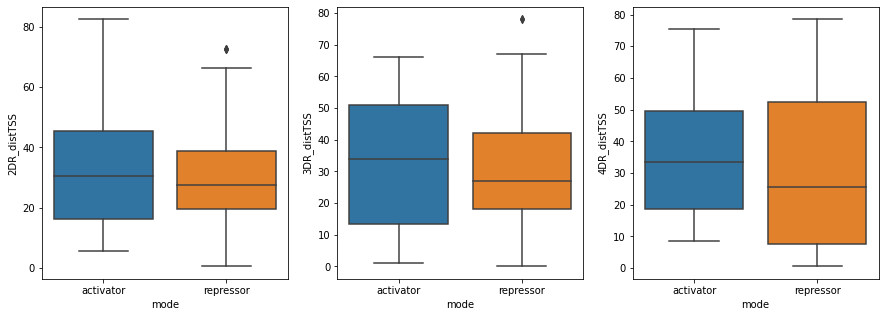

In [40]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(2,5):
    sns.boxplot( arca_tfbs['mode'],DR_table[str(i)+'DR_distTSS'], ax = axs[i-2] )

In [15]:
distTSS_A = {2:[],3:[],4:[]}
distTSS_R = {2:[],3:[],4:[]}

for i in range( len(DR_table['2DR_distTSS']) ):
    for k in distTSS_A.keys():
        if list(DR_table[ str(k)+'DR_score'])[i] >=  cutoff[k]:
            if list(DR_table[ str(k)+'DR_upstream'])[i] == 1:
                tempdist = - list(DR_table[ str(k)+'DR_distTSS'])[i] 
            else: 
                tempdist =  list(DR_table[ str(k)+'DR_distTSS'])[i]

            if list(arca_tfbs['mode'])[i] == 'activator':
                distTSS_A[k].append(tempdist)
            else:
                distTSS_R[k].append( tempdist )

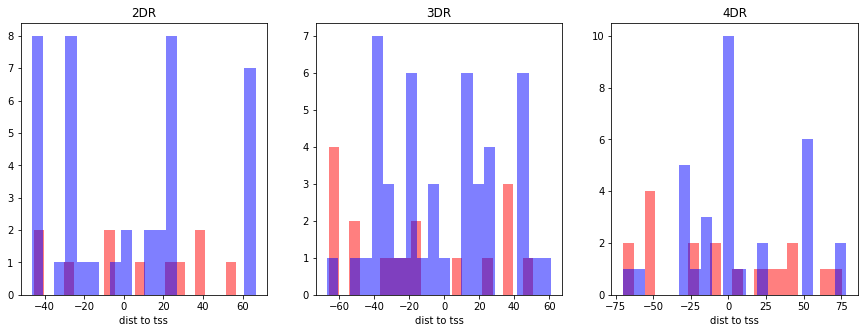

In [16]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(2,5):
    axs[i-2].hist(distTSS_A[i],bins=20,color = 'red',alpha=0.5,label='activator')
    axs[i-2].hist(distTSS_R[i],bins=20,color = 'blue',alpha=0.5,label='repressor')
    axs[i-2].set_title(str(i)+'DR')
    axs[i-2].set_xlabel( 'dist to tss')

In [17]:
arca_merge = pd.concat([DR_table,arca_tfbs],axis=1)
arca_merge = arca_merge.drop(columns=['tu_id'])
arca_merge['tu_id'] = list(arca_tfbs['tu_id'])
arca_merge.head()

,1DR_score,1DR_distTSS,1DR_upstream,seq,2DR_score,2DR_distTSS,2DR_upstream,3DR_score,3DR_distTSS,3DR_upstream,...,left,right,mode,final_state,tf,strand,tss,operon_id,operon_name,tu_id
0,-7.385229,35.0,1,AATCCACCATCAATTTGCACACATTATTATGTGATAATTGCCAACC...,-19.459980,29.5,1,-37.505847,35.0,1,...,656416,656430,activator,ArcA-Phosphorylated,ArcA,-1.0,656083.0,ECK120014406,dcuC,ECK120010895
1,-7.531123,15.0,0,ACCACTTCGCAAATAGGGCGACGTTCATCTTTCATTCCCGGACCTC...,-19.154858,20.5,0,-33.189578,26.0,0,...,3128180,3128194,repressor,ArcA-Phosphorylated,ArcA,-1.0,3128206.0,ECK120014421,glcDEFGBA,ECK120008963
2,-10.265968,57.0,1,GCCTCGAAAATTGATCAAACATACGTATTATCTTGCTTTAATTAAT...,-26.469297,17.5,0,-41.257000,62.0,1,...,3146413,3146427,repressor,ArcA-Phosphorylated,ArcA,-1.0,3146363.0,ECK120014813,hybOABCDEFG,ECK120009478
3,-9.576925,75.0,0,GTTGCAGACTCATCTGCGCGCGGCTAATTGCACCTGCGCCACCATG...,-26.128886,19.5,0,-38.891278,36.0,0,...,866524,866538,activator,ArcA-Phosphorylated,ArcA,-1.0,866537.0,ECK120014823,moeAB,ECK120026769
4,-7.097186,94.0,1,TGTGTTAATAAAAAACCTCAAGTTCTCACTTACAGAAACTTTTGTG...,-25.079852,19.5,0,-43.110273,63.0,1,...,4360278,4360292,repressor,ArcA-Phosphorylated,ArcA,-1.0,4360106.0,ECK120014709,cadBA,ECK120009649


In [18]:
IM_tuids = []
for g_tag in IM_genes['ArcA']:
    if g_tag == 'b4735':
        continue
    left =  int(mg1655.gene_table.loc[g_tag].left)
    right =  int(mg1655.gene_table.loc[g_tag].right )
    temp = mg1655.features_in_range(left,right)
    temp = temp[temp['type']=='tu']
    IM_tuids.append( list(temp.index)[0] )
IM_tuids = list( set(IM_tuids))

{'ECK120008989', 'ECK120009298'}
{'ECK120008963', 'ECK120009169', 'ECK120009308', 'ECK120009720', 'ECK120009307', 'ECK120009298', 'ECK120026913', 'ECK120009406'}


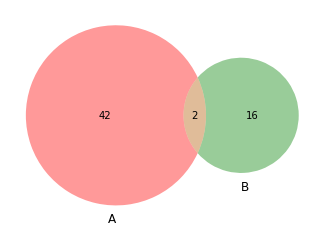

In [19]:
from matplotlib_venn import venn2
tuids_act = list( arca_merge[arca_merge['mode']=='activator']['tu_id'] )
tuids_rep = list( arca_merge[arca_merge['mode']=='repressor']['tu_id'] )
venn2([set(IM_tuids ),set(tuids_act)])
print( set(IM_tuids )&set(tuids_act))
print( set(IM_tuids )&set(tuids_rep))
tus_tocheck = list(set(IM_tuids )&set(tuids_act) ) + list( set(IM_tuids )&set(tuids_rep) )
tus_mode = ['activator' for i in range(2)] + ['repressor' for i in range(8)]

In [20]:
_2DRsites = ['msrB','ompW','acnB','cstA','ynaj','nepl','ybaY',
             'yjiR','putP','fadl','mglB','ubiC','pdhR','fadH']

_2DR_tus = []
for op in _2DRsites:
    if op in list(arca_merge['operon_name']):
        temp = arca_merge[arca_merge['operon_name']== op ]
        _2DR_tus = _2DR_tus + list(temp['tu_id'])
_2DR_tus = list( set(_2DR_tus))
print(_2DR_tus)

['ECK120027533', 'ECK120021227', 'ECK120009828']


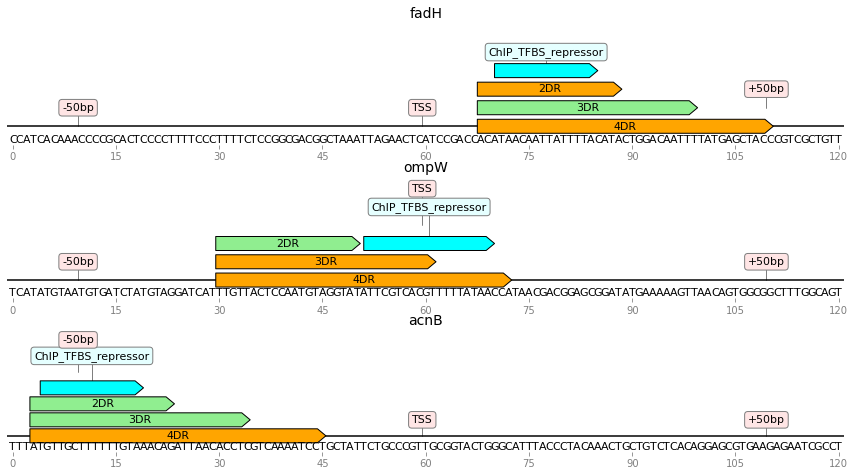

In [23]:
colors =['lightgreen', 'orange']

fig, axs = plt.subplots( len(_2DR_tus), 1,figsize=(15,8) )
for i in range( len(_2DR_tus) ):
    tu_id = _2DR_tus[i]
    temp_table = arca_merge[arca_merge['tu_id']== tu_id ]
    op_name = list(temp_table['operon_name'])[0]
    temp_seq = list(temp_table['seq'])[0][40:161]
    features = [ GraphicFeature(start= 60, end=60, strand=+1, color='red',label="TSS"),
               GraphicFeature(start= 10, end=10, strand=+1, color='red',label="-50bp"),
               GraphicFeature(start= 110, end=110, strand=+1, color='red',label="+50bp")]
    for  j in range(len(temp_table['left'])):
        tfbs_left = list(temp_table['left'])[j]
        tfbs_right = list(temp_table['right'])[j]
        tss =  list(temp_table['tss'])[j]
        distTSS =  (tfbs_left+tfbs_right)/2 - tss
        mid = 60 + distTSS
        width = abs(tfbs_left-tfbs_right)+1
        mode = list(temp_table['mode'])[j]
        if mode == 'activator':
            text = "ChIP_TFBS"+"_activator"
        else:
            text = "ChIP_TFBS"+"_repressor"
        if mid >10 and mid < 200:
            features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =text ) )
    
    for k in [2,3,4]:
        distTSS = list(temp_table[str(k)+'DR_distTSS'])[0]
        
        if list(temp_table[str(k)+'DR_score'])[0] > cutoff[k]:
            temp_color = colors[0]
        else:
            temp_color = colors[1]
        
        if list(temp_table[str(k)+'DR_upstream'])[0] == 1:
            mid = 60 - distTSS
        else:
            mid = 60 + distTSS
        width = len(PWM_DR[k])
        features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color=temp_color,label = str(k)+"DR") )
    
    
    
    record = GraphicRecord(sequence_length= 121 , sequence= temp_seq , features=features )
    record.plot(figure_width=5, ax = axs[i])
    record.plot_sequence(ax = axs[i])
    axs[i].set_title( op_name, pad = -1,fontsize=14,y=1.0 )
#plt.suptitle('2DR')
plt.savefig('../../../thesis_plots/ArcA_promoters.svg')

In [55]:
_3DR_sites =['mqo','yncD','glpD','argT','acs','trxC','fdoG','hcaR',
            'clpA','gltA','ydcl','sthA','lldP','mdh','kefG','glcC','fadE',
            'fadL','mhpR','csgD','fadD','putA','ugpB','icdA','cyoA','tpx',
            'lpdA','gcd']

_3DR_tus = []
for op in _3DR_sites:
    if op in list(arca_merge['operon_name']):
        temp = arca_merge[arca_merge['operon_name']== op ]
        _3DR_tus = _3DR_tus + list(temp['tu_id'])
_3DR_tus = list( set(_3DR_tus))
print(_3DR_tus)

['ECK120009273', 'ECK120009298', 'ECK120009300', 'ECK120011140', 'ECK120021211']


Text(0.5, 0.9, '3DR')

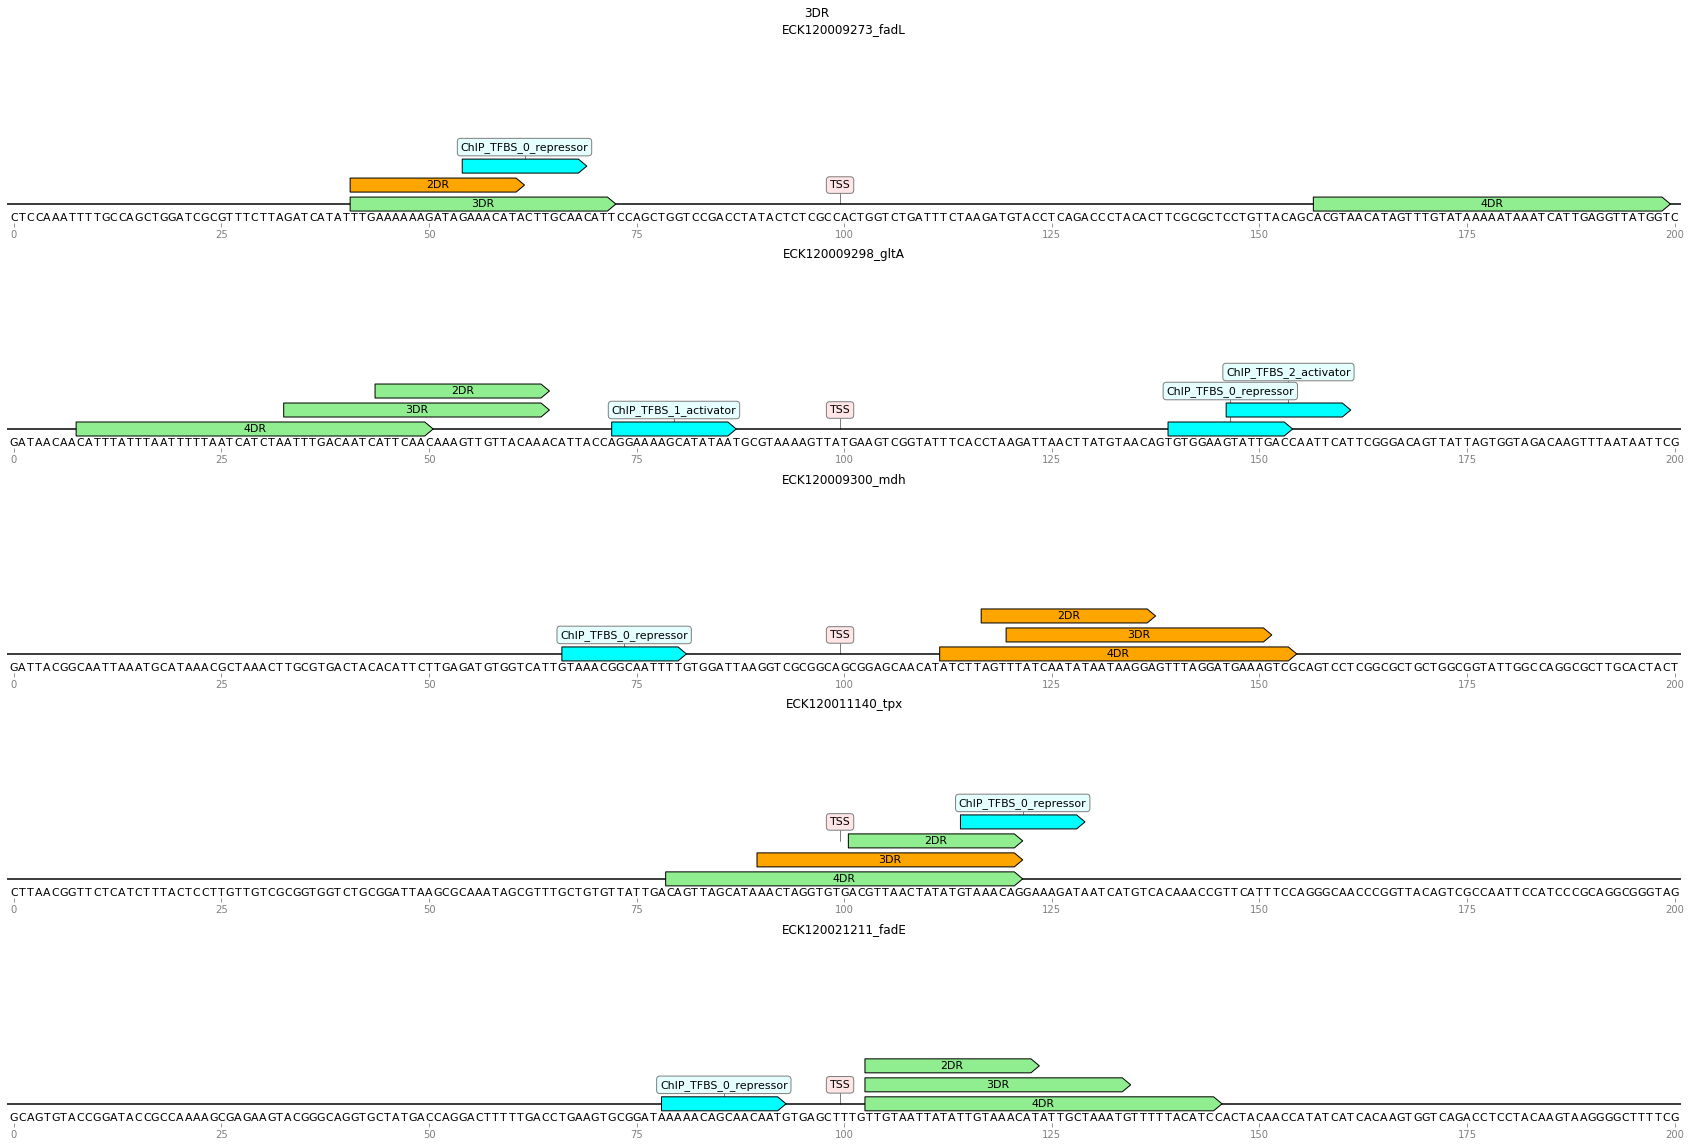

In [58]:
colors =['lightgreen', 'orange']

fig, axs = plt.subplots( len(_3DR_tus), 1,figsize=(30,20) )
for i in range( len(_3DR_tus) ):
    tu_id = _3DR_tus[i]
    temp_table = arca_merge[arca_merge['tu_id']== tu_id ]
    op_name = list(temp_table['operon_name'])[0]
    temp_seq = list(temp_table['seq'])[0]
    features = [ GraphicFeature(start= 100, end=100, strand=+1, color='red',label="TSS") ]
    for  j in range(len(temp_table['left'])):
        tfbs_left = list(temp_table['left'])[j]
        tfbs_right = list(temp_table['right'])[j]
        tss =  list(temp_table['tss'])[j]
        distTSS =  (tfbs_left+tfbs_right)/2 - tss
        mid = 100 + distTSS
        width = abs(tfbs_left-tfbs_right)+1
        mode = list(temp_table['mode'])[j]
        if mode == 'activator':
            text = "ChIP_TFBS_"+str(j)+"_activator"
        else:
            text = "ChIP_TFBS_"+str(j)+"_repressor"
        if mid >0 and mid < 200:
            features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =text ) )
    
    for k in [2,3,4]:
        distTSS = list(temp_table[str(k)+'DR_distTSS'])[0]
        
        if list(temp_table[str(k)+'DR_score'])[0] > cutoff[k]:
            temp_color = colors[0]
        else:
            temp_color = colors[1]
        
        if list(temp_table[str(k)+'DR_upstream'])[0] == 1:
            mid = 100 - distTSS
        else:
            mid = 100 + distTSS
        width = len(PWM_DR[k])
        features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color=temp_color,label = str(k)+"DR") )
    
    
    
    record = GraphicRecord(sequence_length= 201 , sequence= temp_seq , features=features )
    record.plot(figure_width=5, ax = axs[i])
    record.plot_sequence(ax = axs[i])
    axs[i].set_title( tu_id +'_'+ op_name, pad = -0.05 )
plt.suptitle('3DR', y=0.9)

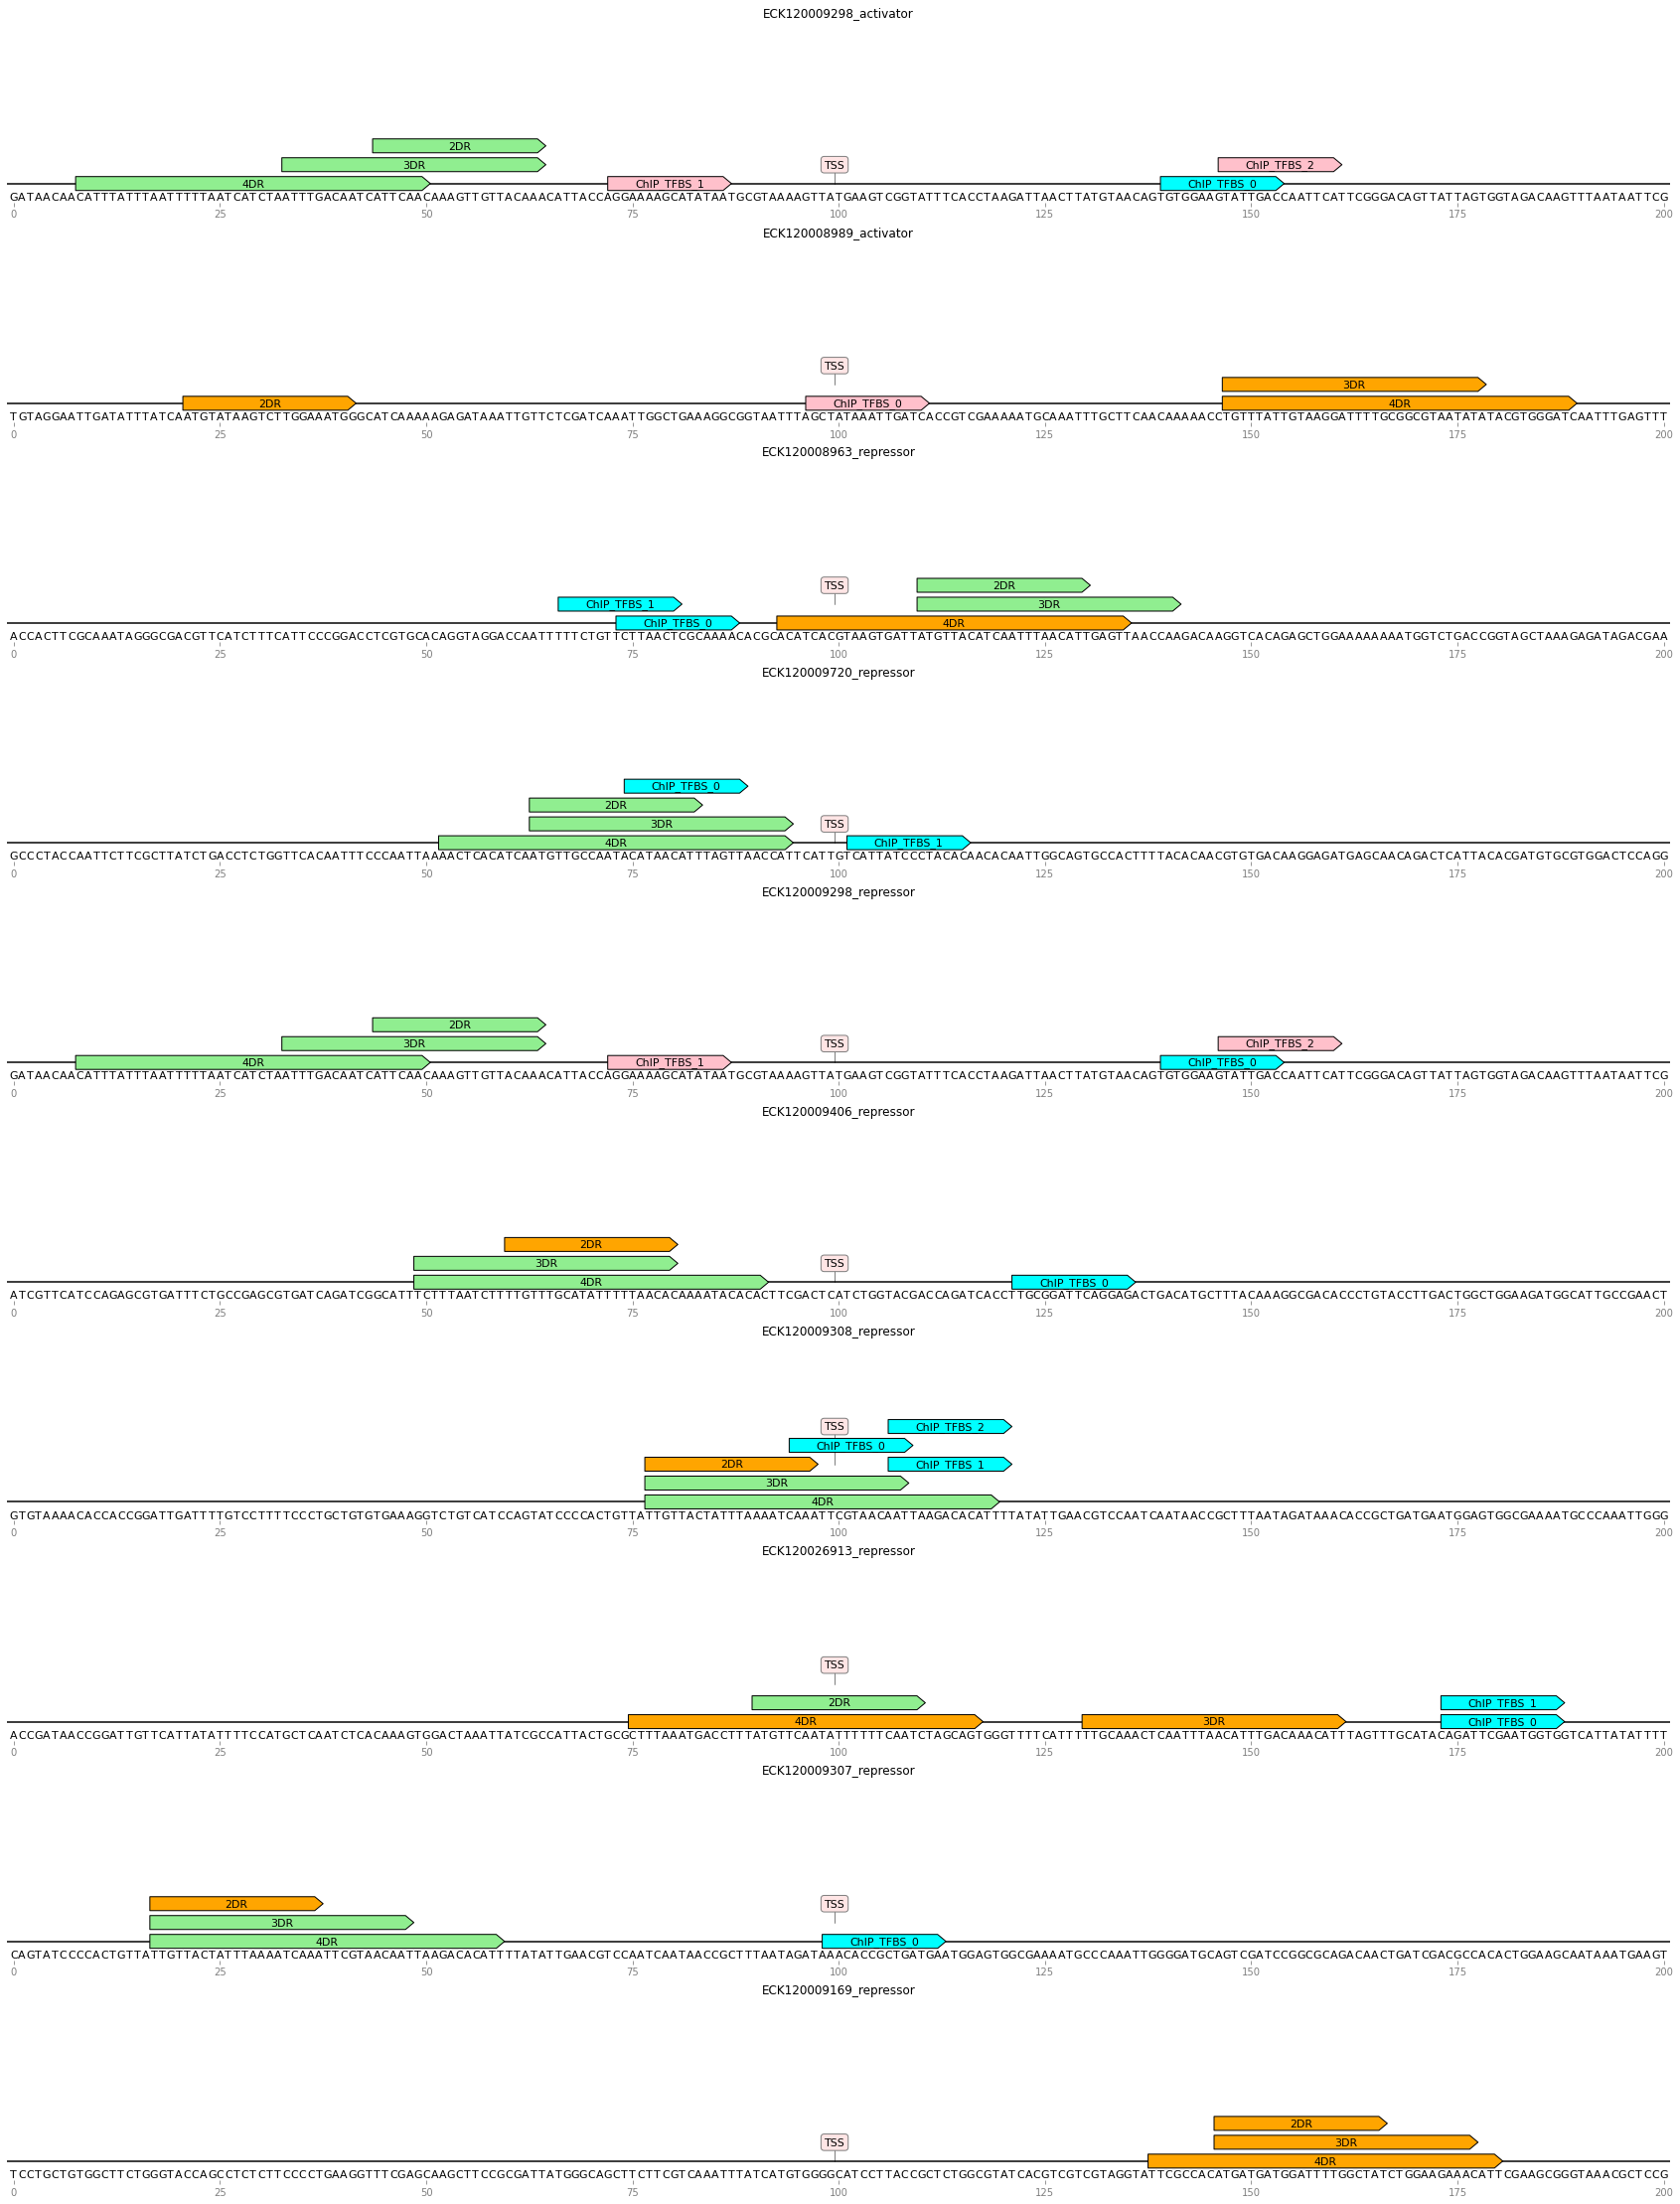

In [59]:
colors =['lightgreen', 'orange']

fig, axs = plt.subplots( len(tus_tocheck), 1, figsize = (30,40) )
for i in range( len(tus_tocheck) ):
    temp_seq = list(arca_merge[arca_merge['tu_id']==tus_tocheck[i]]['seq'])[0]
    tu_id = tus_tocheck[i]
    features = [ GraphicFeature(start= 100, end=100, strand=+1, color='red',label="TSS") ]
    
    temp_table = arca_merge[arca_merge['tu_id']==tus_tocheck[i]]
    for j in range( len(temp_table['left'])):
        tfbs_left = list(temp_table['left'])[j]
        tfbs_right = list(temp_table['right'])[j]
        tss =  list(temp_table['tss'])[j]
        distTSS =  (tfbs_left+tfbs_right)/2 - tss
        mid = 100 + distTSS
        width = abs(tfbs_left-tfbs_right)+1
        if list(temp_table['mode'])[j] == 'activator':
            temp_color = 'pink'
        else:
            temp_color = 'cyan'
        if mid >0 and mid < 200:
            features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                             color= temp_color,label = "ChIP_TFBS_"+str(j)) )
    
    for k in [2,3,4]:
        distTSS = list(arca_merge[arca_merge['tu_id']==tus_tocheck[i]][str(k)+'DR_distTSS'])[0]
        
        if list(arca_merge[arca_merge['tu_id']==tus_tocheck[i]][str(k)+'DR_score'])[0] > cutoff[k]:
            temp_color = colors[0]
        else:
            temp_color = colors[1]
        
        if list(arca_merge[arca_merge['tu_id']==tus_tocheck[i]][str(k)+'DR_upstream'])[0] == 1:
            mid = 100 - distTSS
        else:
            mid = 100 + distTSS
        width = len(PWM_DR[k])
        features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color=temp_color,label = str(k)+"DR") )
    
    
    
    record = GraphicRecord(sequence_length= 201 , sequence= temp_seq , features=features )
    record.plot(figure_width=5, ax = axs[i])
    record.plot_sequence(ax = axs[i])
    axs[i].set_title( tus_tocheck[i] +'_'+tus_mode[i], pad = -0.05 )

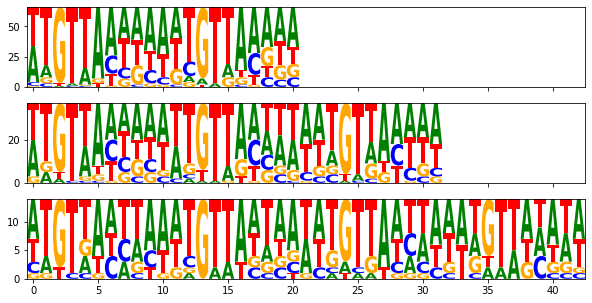

In [55]:
fig, axs = plt.subplots(3,1,figsize=(10,5),sharex=True)
for i in [2,3,4]:
    lm.Logo( cm[i], ax = axs[i-2])

In [24]:
def score_profile( seq, pssm ):
    width = len(pssm)
    scores = []
    for i in range(0,len(seq) + 1 - width ):
        scores.append( score_motif(seq[i:i+width], pssm) )
    if width % 2 == 1:
        scores = [ 0 for j in range( int(width/2) )] + scores
        scores = scores + [ 0 for j in range( int(width/2) )]
    elif width % 2 == 0:
        scores = [ 0 for j in range( int(width/2) )] + scores
        scores = scores + [ 0 for j in range( int(width/2) - 1 )]
        
    return scores

# Fnr

In [5]:
raw_data = pd.read_csv('../data.csv')
raw_data.head()

,ID,gene,TU,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,...,EP_TSS_1,EP_TSS_2,EP_TSS_3,EP_TSS_4,EP_TSS_5,EP_TSS_6,EP_TSS_7,EP_TSS_8,EP_TSS_9,EP_TSS_10
0,b0008,talB,talB,1,1040,1,0,0,-13,-4.060455,...,-7.41,-8.13,-8.79,-5.82,-7.34,-6.16,-8.05,-9.42,-8.51,-7.43
1,b0014,dnaK,dnaK-tpke11-dnaJ,1,3251,1,0,0,-11,-8.656225,...,-9.42,-13.59,-8.77,-7.32,-5.39,-5.57,-5.16,-5.08,-6.89,-5.90
2,b0014,dnaK,dnaK-tpke11-dnaJ,1,3176,1,0,0,-13,-6.814542,...,-5.70,-7.44,-5.56,-5.89,-8.27,-7.85,-6.93,-6.73,-5.60,-7.78
3,b0014,dnaK,dnaK-tpke11-dnaJ,1,3155,1,0,0,-15,-6.423808,...,-8.38,-8.77,-7.32,-5.80,-5.40,-7.03,-7.10,-7.12,-5.43,-5.03
4,b0015,dnaJ,dnaK-tpke11-dnaJ,1,3251,1,0,0,-11,-8.656225,...,-9.42,-13.59,-8.77,-7.32,-5.39,-5.57,-5.16,-5.08,-6.89,-5.90


In [6]:
pwm_im = rlogodds('../data/motif_logodds.txt')
pwm_db = rpwm('../data/motif_pwm_db.txt')

## IHF_Lrp

In [7]:
IHF_Lrp = list(set(raw_data['ID'])&set(IM_genes['Fnr+IHF+gcvB']) )
IHF_Lrp_tus = []
for gene_id in IHF_Lrp:
    temp = mg1655.gene_table[mg1655.gene_table.index==gene_id]
    left =  list( temp['left'])[0]
    right = list( temp['right'])[0]
    temp = mg1655.features_in_range(left,right)
    temp = temp[temp['type']=='tu']
    IHF_Lrp_tus.append( list(temp.index)[0] )
IHF_Lrp_tus = list( set(IHF_Lrp_tus))
print(IHF_Lrp_tus)

['ECK120009445', 'ECK120009452', 'ECK120027540']


In [8]:
IHF_Lrp_tus  = ['ECK120009445','ECK120009452']

IHF_Lrp_records = []
IHF_Lrp_seq_names = []

feature_list = ['Fnr','IHF','Lrp']
feature_width = [14,14,13]

N_UPSTREAM = 150
N_DOWNSTREAM = 50
    
for i in range(len(IHF_Lrp_tus)):
    features = [ GraphicFeature(start= N_UPSTREAM, end= N_UPSTREAM , strand=+1, color='red',label="TSS"),
               GraphicFeature(start= 0, end= 0 , strand=+1, color='red',label="-"+str(N_UPSTREAM)+"bp"),
               GraphicFeature(start= N_UPSTREAM+N_DOWNSTREAM, end= N_UPSTREAM+N_DOWNSTREAM , 
                              strand=+1, color='red',label="+"+str(N_DOWNSTREAM)+"bp")]
    
    tu_id = IHF_Lrp_tus[i]
    temp = mg1655.tu_table[mg1655.tu_table.index == tu_id ]
    tss = int(list(temp['tss'])[0])
    strand = list(temp['strand'])[0]
    tu_name = list(temp['name'])[0]
    print(str(tu_id) + str(tu_name) )
    tu_length = int( list(temp['right'])[0] - list(temp['left'])[0] + 1 )
    sub_raw_data = raw_data[ (raw_data['TU']==tu_name) & (raw_data['TU_length']==tu_length) ]
    box_10_L = list(temp['box_10_left'])[0]
    box_10_R = list(temp['box_10_right'])[0]
    box_35_L = list(temp['box_35_left'])[0]
    box_35_R = list(temp['box_35_right'])[0]
    sig_name = list(temp['sigma_factor'])[0]
    if strand == 1:
        features.append( GraphicFeature(start= N_UPSTREAM+(box_10_L-tss), end= N_UPSTREAM+(box_10_R-tss), 
                                    strand=+1, color='orange',label=sig_name+"_-10 box") )
        features.append( GraphicFeature(start= N_UPSTREAM+(box_35_L-tss), end= N_UPSTREAM+(box_35_R-tss),
                                    strand=+1, color='orange',label=sig_name+"_-35 box") )
    else:
        features.append( GraphicFeature(start= N_UPSTREAM-(box_10_R-tss), end= N_UPSTREAM-(box_10_L-tss), 
                                    strand=+1, color='orange',label=sig_name+"_-10 box") )
        features.append( GraphicFeature(start= N_UPSTREAM-(box_35_R-tss), end= N_UPSTREAM-(box_35_L-tss),
                                    strand=+1, color='orange',label=sig_name+"_-35 box") )
        
    
    if len(sub_raw_data['ID']) < 1:
        continue
    for f_name in feature_list:
        distToTSS = list(sub_raw_data[f_name+' distToTSS'])[0]
        if list(sub_raw_data[f_name+' upstreamTSS'])[0] == 1:
            mid = N_UPSTREAM - distToTSS 
        else:
            mid = N_UPSTREAM + distToTSS
        width =  feature_width[ feature_list.index(f_name) ]
        features.append( GraphicFeature(start= mid-width/2, end= mid+width/2,
                                        strand=+1, color='lightgreen',label=f_name+" matched") )
    if strand == 1:
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
        
    seq = seq_loc.extract( mg1655.sequence)
    if strand ==1:
        temp = mg1655.features_in_range(tss - N_UPSTREAM - 1, tss + N_DOWNSTREAM)
    else:
        temp = mg1655.features_in_range( tss - N_DOWNSTREAM - 1,  tss + N_UPSTREAM )
    #op_temp = temp[temp['type']=='operon']
    #op_name = list(op_temp['name'])[0]
    if 'tfbs' in list (temp['type']):
        temp = temp[temp['type']=='tfbs']
        temp = temp[(temp['tf']=='FNR')|(temp['tf']=='IHF')|(temp['tf']=='Lrp')]
        for j in range(len(temp['left'])):
            if j not in [12,15,0,3,6]:
                continue
            tfbs_left = list(temp['left'])[j]
            tfbs_right = list(temp['right'])[j]
            distTSS =  (tfbs_left+tfbs_right)/2 - tss
            mid = N_UPSTREAM + distTSS
            width = 14
            features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =list(temp['tf'])[j]+"_ChIP_TFBS" ) )
        
    IHF_Lrp_records.append( GraphicRecord(sequence_length= N_UPSTREAM+N_DOWNSTREAM+1 , sequence= seq , features=features ) )
    IHF_Lrp_seq_names.append( tu_name )

ECK120009445dadAX
ECK120009452dppABCDF


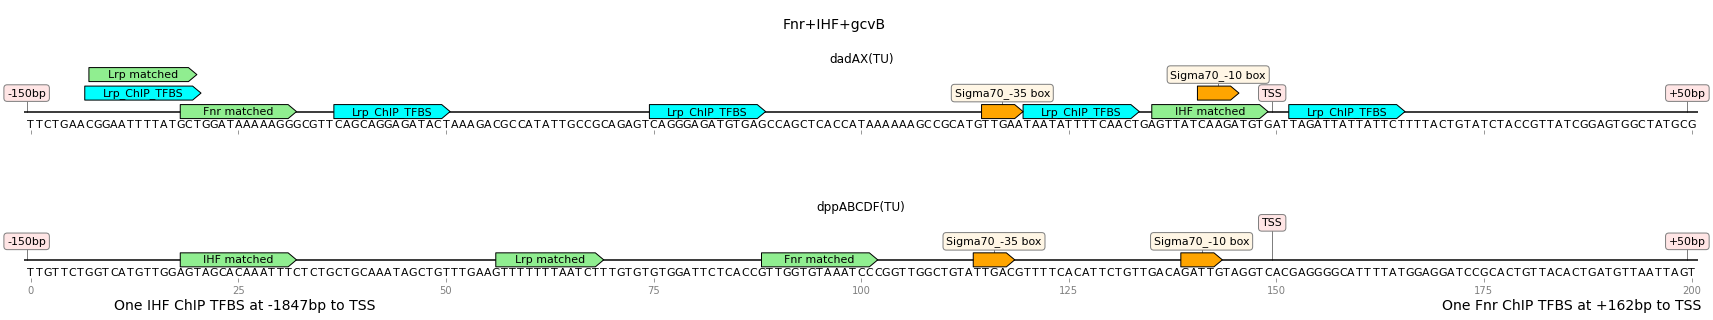

In [9]:
fig, axs = plt.subplots( len(IHF_Lrp_seq_names), 1,figsize=(30,5), sharex=True  )
for i in range(len(IHF_Lrp_seq_names)):
    IHF_Lrp_records[i].plot(figure_width=5, ax = axs[i])
    IHF_Lrp_records[i].plot_sequence(ax = axs[i],fontdict={'size': 8})
    axs[i].set_title(IHF_Lrp_seq_names[i]+"(TU)",y = 0.5 )
    #axs[i].set_xlim([0,175])
axs[1].text(170,-2.7,"One Fnr ChIP TFBS at +162bp to TSS",fontsize=14)
axs[1].text(10,-2.7,"One IHF ChIP TFBS at -1847bp to TSS",fontsize=14)
fig.suptitle('Fnr+IHF+gcvB',y=0.85,fontsize=14)
fig.savefig('../../../thesis_plots/FnrIHF_promoters.svg',dpi=150)

## Fnr_NarL

In [41]:
Fnr_NarL = list(set(raw_data['ID'])&set(IM_genes['Fnr+NarL']) )
Fnr_NarL_tus = []
for gene_id in Fnr_NarL:
    temp = mg1655.gene_table[mg1655.gene_table.index==gene_id]
    left =  list( temp['left'])[0]
    right = list( temp['right'])[0]
    temp = mg1655.features_in_range(left,right)
    temp = temp[temp['type']=='tu']
    Fnr_NarL_tus.append( list(temp.index)[0] )
Fnr_NarL_tus = list( set(Fnr_NarL_tus))
print(Fnr_NarL_tus)

['ECK120009239', 'ECK120009348', 'ECK120009493', 'ECK120009238', 'ECK120009237']


In [45]:
Fnr_NarL_records = []
Fnr_NarL_seq_names = []
score_levels = {'Fnr-1 im':[],'Fnr-2 im':[],'Fnr':[]}

feature_list = ['Fnr','Fnr-1 im','Fnr-2 im','NarL','NarP']
feature_width = {'Fnr':14,'Fnr-1 im':16,'Fnr-2 im':16,'NarL':17,'NarP':16}

N_UPSTREAM = 150
N_DOWNSTREAM = 50
    
for i in range(len(Fnr_NarL_tus)):
    features = [ GraphicFeature(start= N_UPSTREAM, end= N_UPSTREAM , strand=+1, color='red',label="TSS"),
               GraphicFeature(start= 0, end= 0 , strand=+1, color='red',label="-"+str(N_UPSTREAM)+"bp"),
               GraphicFeature(start= N_UPSTREAM+N_DOWNSTREAM, end= N_UPSTREAM+N_DOWNSTREAM , 
                              strand=+1, color='red',label="+"+str(N_DOWNSTREAM)+"bp")]
    
    tu_id = Fnr_NarL_tus[i]
    if tu_id == 'ECK120009493':
        continue
    temp = mg1655.tu_table[mg1655.tu_table.index == tu_id ]
    tss = int(list(temp['tss'])[0])
    strand = list(temp['strand'])[0]
    tu_name = list(temp['name'])[0]
    tu_length = int( list(temp['right'])[0] - list(temp['left'])[0] + 1 )
    sub_raw_data = raw_data[ (raw_data['TU']==tu_name) & (raw_data['TU_length']==tu_length) ]
    box_10_L = list(temp['box_10_left'])[0]
    box_10_R = list(temp['box_10_right'])[0]
    box_35_L = list(temp['box_35_left'])[0]
    box_35_R = list(temp['box_35_right'])[0]
    sig_name = list(temp['sigma_factor'])[0]
    if strand == 1:
        features.append( GraphicFeature(start= N_UPSTREAM+(box_10_L-tss), end= N_UPSTREAM+(box_10_R-tss), 
                                    strand=+1, color='orange',label=sig_name+"_-10 box") )
        features.append( GraphicFeature(start= N_UPSTREAM+(box_35_L-tss), end= N_UPSTREAM+(box_35_R-tss),
                                    strand=+1, color='orange',label=sig_name+"_-35 box") )
    else:
        features.append( GraphicFeature(start= N_UPSTREAM-(box_10_R-tss), end= N_UPSTREAM-(box_10_L-tss), 
                                    strand=+1, color='orange',label=sig_name+"_-10 box") )
        features.append( GraphicFeature(start= N_UPSTREAM-(box_35_R-tss), end= N_UPSTREAM-(box_35_L-tss),
                                    strand=+1, color='orange',label=sig_name+"_-35 box") )
        
    
    if len(sub_raw_data['ID']) < 1:
        continue
    for f_name in feature_list:
        distToTSS = list(sub_raw_data[f_name+' distToTSS'])[0]
        if list(sub_raw_data[f_name+' upstreamTSS'])[0] == 1:
            mid = 150 - distToTSS 
        else:
            mid = 150 + distToTSS
        width =  feature_width[ f_name ]
        features.append( GraphicFeature(start= mid-width/2, end= mid+width/2,
                                        strand=+1, color='lightgreen',label=f_name+" matched") )
    
    if strand == 1:
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
        
    seq = seq_loc.extract( mg1655.sequence)
    for k in ['Fnr-1 im','Fnr-2 im']:
        score_levels[k].append( score_profile( seq, pwm_im[k[:-3]] ) )
    score_levels['Fnr'].append( score_profile(seq,pwm_db['Fnr']))  
    if strand ==1:
        temp = mg1655.features_in_range(tss - N_UPSTREAM - 1, tss + N_DOWNSTREAM)
    else:
        temp = mg1655.features_in_range( tss - N_DOWNSTREAM - 1,  tss + N_UPSTREAM )
    temp = temp[temp['type']=='tfbs']
    temp = temp[(temp['tf']=='FNR')|(temp['tf']=='NarL')|(temp['tf']=='NarP')]
    for j in range(len(temp['left'])):
        tfbs_left = list(temp['left'])[j]
        tfbs_right = list(temp['right'])[j]
        distTSS =  (tfbs_left+tfbs_right)/2 - tss
        mid = 150 + distTSS
        if list(temp['tf'])[j] == 'FNR':
            width = feature_width['Fnr']
        else:
            width = feature_width[ list(temp['tf'])[j] ]
                
        if mid >0 and mid < 200:
            features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =list(temp['tf'])[j]+"_ChIP_TFBS" ) )
        
    Fnr_NarL_records.append( GraphicRecord(sequence_length= 201 , sequence= seq , features=features ) )
    Fnr_NarL_seq_names.append(tu_name)

Text(0.5, 0.9, 'Fnr+NarL')

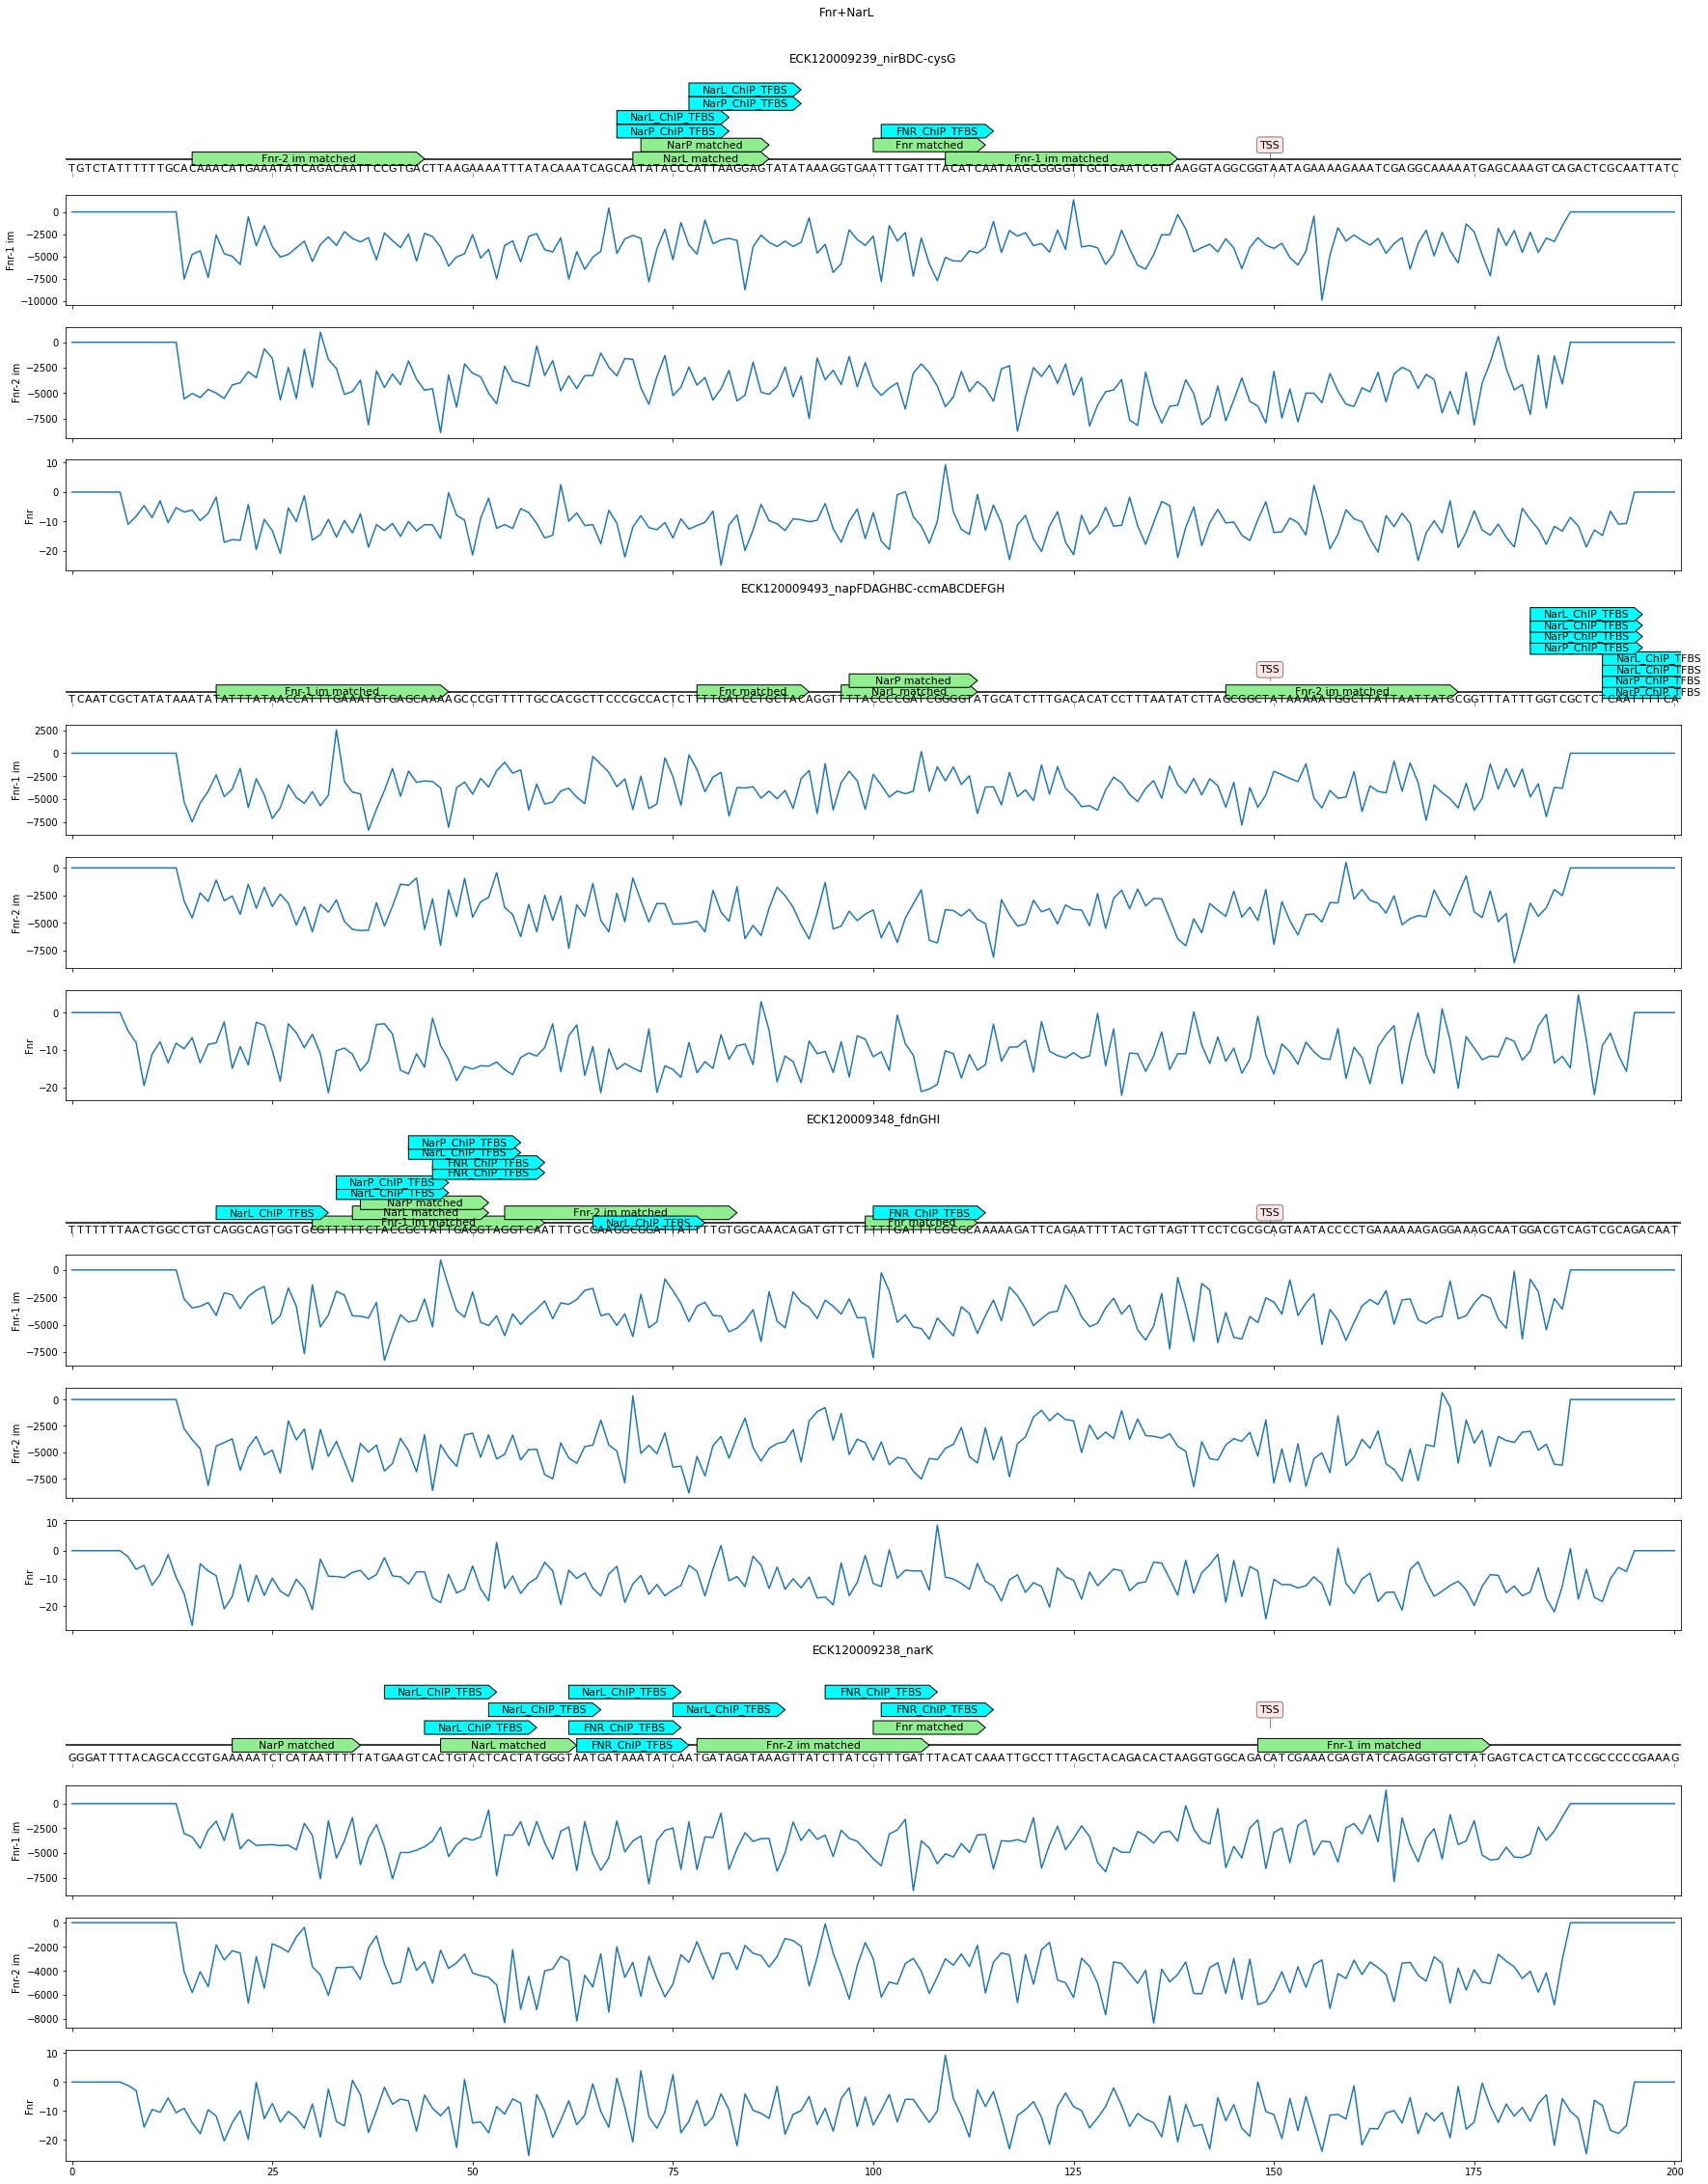

In [68]:
fig, axs = plt.subplots( len(Fnr_NarL_seq_names)*4, 1,figsize=(30,40), sharex=True  )
for i in range(len(Fnr_NarL_seq_names)):
    Fnr_NarL_records[i].plot(figure_width=5, ax = axs[i*4])
    Fnr_NarL_records[i].plot_sequence(ax = axs[i*4])
    axs[i*4].set_title( Fnr_NarL_seq_names[i], pad = -0.05 )
    xx =np.arange(201)
    axs[i*4+1].plot(xx,score_levels['Fnr-1 im'][i])
    axs[i*4+1].set_ylabel( 'Fnr-1 im' )
    axs[i*4+2].plot(xx,score_levels['Fnr-2 im'][i])
    axs[i*4+2].set_ylabel( 'Fnr-2 im' )
    axs[i*4+3].plot(xx,score_levels['Fnr'][i])
    axs[i*4+3].set_ylabel( 'Fnr' )
    
fig.suptitle('Fnr+NarL',y=0.9)

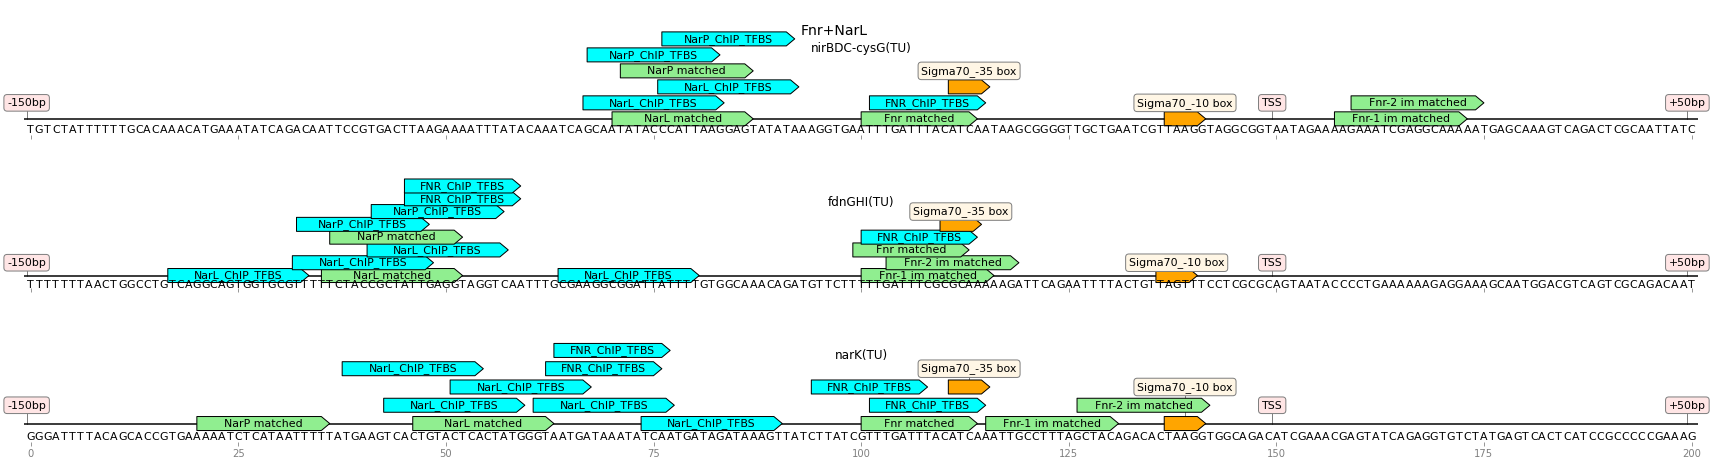

In [50]:
fig, axs = plt.subplots( len(Fnr_NarL_seq_names), 1,figsize=(30,8), sharex=True  )
for i in range(len(Fnr_NarL_seq_names)):
    Fnr_NarL_records[i].plot(figure_width=5, ax = axs[i])
    Fnr_NarL_records[i].plot_sequence(ax = axs[i],fontdict={'size': 8})
    axs[i].set_title(Fnr_NarL_seq_names[i]+"(TU)",y = 0.6 )
fig.suptitle('Fnr+NarL',y=0.85,fontsize=14)
fig.savefig('../../../thesis_plots/FnrNarL_promoters.svg',dpi=150)

In [42]:
Fnr_NarL_seq_names

['fdnGHI', 'narK', 'napFDAGHBC-ccmABCDEFGH', 'nirBDC-cysG']

## Fnr_NarLP

In [12]:
Fnr_NarLP = list(set(raw_data['ID'])&set(IM_genes['Fnr+NarLP']) )
Fnr_NarLP_tus = []
for gene_id in Fnr_NarLP:
    temp = mg1655.gene_table[mg1655.gene_table.index==gene_id]
    left =  list( temp['left'])[0]
    right = list( temp['right'])[0]
    temp = mg1655.features_in_range(left,right)
    temp = temp[temp['type']=='tu']
    Fnr_NarLP_tus.append( list(temp.index)[0] )
Fnr_NarLP_tus = list( set(Fnr_NarLP_tus))
print(Fnr_NarLP_tus)

['ECK120009390', 'ECK120009237', 'ECK120009239', 'ECK120009493']


In [13]:
Fnr_NarLP_records = []
Fnr_NarLP_seq_names = []

score_levels = {'Fnr-1 im':[],'Fnr-2 im':[],'Fnr':[]}
feature_list = ['Fnr','Fnr-1 im','Fnr-2 im','NarL','NarP']
feature_width = {'Fnr':14,'Fnr-1 im':16,'Fnr-2 im':16,'NarL':17,'NarP':16}

N_UPSTREAM = 150
N_DOWNSTREAM = 50

for i in range(len(Fnr_NarLP_tus)):
    features = [ GraphicFeature(start= N_UPSTREAM, end= N_UPSTREAM , strand=+1, color='red',label="TSS"),
               GraphicFeature(start= 0, end= 0 , strand=+1, color='red',label="-"+str(N_UPSTREAM)+"bp"),
               GraphicFeature(start= N_UPSTREAM+N_DOWNSTREAM, end= N_UPSTREAM+N_DOWNSTREAM , 
                              strand=+1, color='red',label="+"+str(N_DOWNSTREAM)+"bp")]
    
    tu_id = Fnr_NarLP_tus[i]
    
    if tu_id == 'ECK120009493' or  tu_id =='ECK120009239':
        continue
        
    temp = mg1655.tu_table[mg1655.tu_table.index == tu_id ]
    tss = int(list(temp['tss'])[0])
    strand = list(temp['strand'])[0]
    tu_name = list(temp['name'])[0]
    tu_length = int( list(temp['right'])[0] - list(temp['left'])[0] + 1 )
    sub_raw_data = raw_data[ (raw_data['TU']==tu_name) & (raw_data['TU_length']==tu_length) ]
    box_10_L = list(temp['box_10_left'])[0]
    box_10_R = list(temp['box_10_right'])[0]
    box_35_L = list(temp['box_35_left'])[0]
    box_35_R = list(temp['box_35_right'])[0]
    sig_name = list(temp['sigma_factor'])[0]
    if strand == 1:
        features.append( GraphicFeature(start= N_UPSTREAM+(box_10_L-tss), end= N_UPSTREAM+(box_10_R-tss), 
                                    strand=+1, color='orange',label=sig_name+"_-10 box") )
        features.append( GraphicFeature(start= N_UPSTREAM+(box_35_L-tss), end= N_UPSTREAM+(box_35_R-tss),
                                    strand=+1, color='orange',label=sig_name+"_-35 box") )
    else:
        features.append( GraphicFeature(start= N_UPSTREAM-(box_10_R-tss), end= N_UPSTREAM-(box_10_L-tss), 
                                    strand=+1, color='orange',label=sig_name+"_-10 box") )
        features.append( GraphicFeature(start= N_UPSTREAM-(box_35_R-tss), end= N_UPSTREAM-(box_35_L-tss),
                                    strand=+1, color='orange',label=sig_name+"_-35 box") )
    
    if len(sub_raw_data['ID']) < 1:
        continue
    for f_name in feature_list:
        distToTSS = list(sub_raw_data[f_name+' distToTSS'])[0]
        if list(sub_raw_data[f_name+' upstreamTSS'])[0] == 1:
            mid = 150 - distToTSS 
        else:
            mid = 150 + distToTSS
        width =  feature_width[ f_name]
        features.append( GraphicFeature(start= mid-width/2, end= mid+width/2,
                                        strand=+1, color='lightgreen',label=f_name+" matched") )
    
    N_UPSTREAM = 150
    N_DOWNSTREAM = 50
    if strand == 1:
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
        
    seq = seq_loc.extract( mg1655.sequence)
    
    for k in ['Fnr-1 im','Fnr-2 im']:
        score_levels[k].append( score_profile( seq, pwm_im[k[:-3]] ) )
    score_levels['Fnr'].append( score_profile(seq,pwm_db['Fnr']))  
        
    if strand ==1:
        temp = mg1655.features_in_range(tss - N_UPSTREAM - 1, tss + N_DOWNSTREAM)
    else:
        temp = mg1655.features_in_range( tss - N_DOWNSTREAM - 1,  tss + N_UPSTREAM )
    temp = temp[temp['type']=='tfbs']
    temp = temp[(temp['tf']=='FNR')|(temp['tf']=='NarL')|(temp['tf']=='NarP')]
    for j in range(len(temp['left'])):
        tfbs_left = list(temp['left'])[j]
        tfbs_right = list(temp['right'])[j]
        distTSS =  (tfbs_left+tfbs_right)/2 - tss
        mid = 150 + distTSS
        if list(temp['tf'])[j] == 'FNR':
            width = feature_width['Fnr']
        else:
            width = feature_width[ list(temp['tf'])[j] ]
        if mid >0 and mid < 200:
            features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =list(temp['tf'])[j]+"_ChIP_TFBS" ) )
        
    Fnr_NarLP_records.append( GraphicRecord(sequence_length= 201 , sequence= seq , features=features ) )
    Fnr_NarLP_seq_names.append(tu_name)

Text(0.5, 0.9, 'Fnr+NarLP')

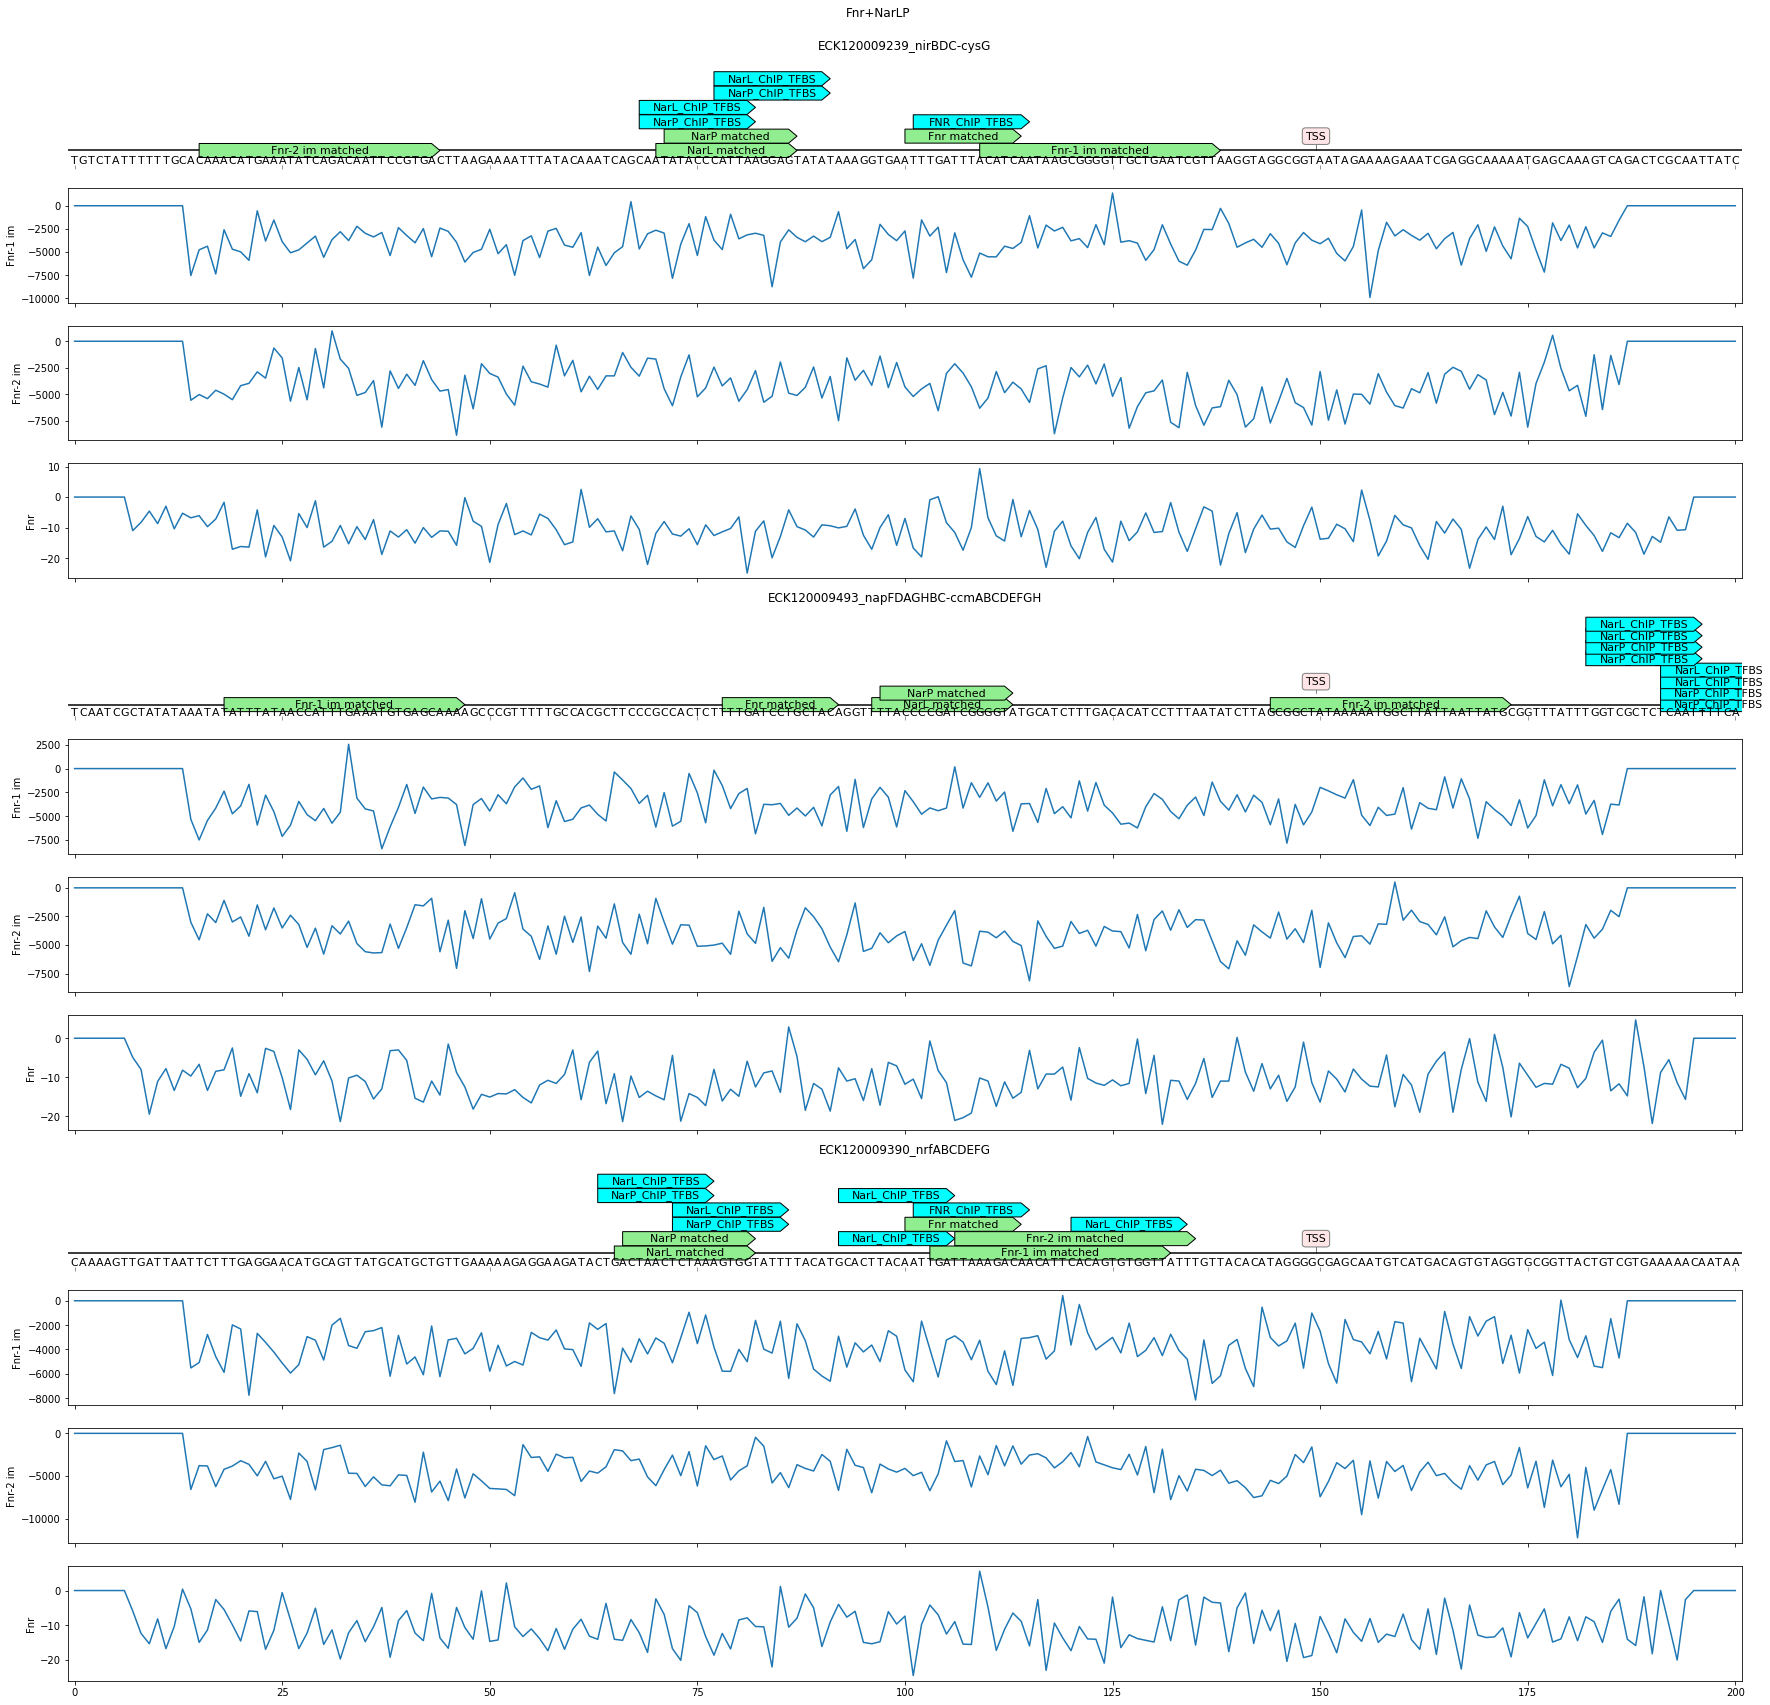

In [82]:
fig, axs = plt.subplots( len(Fnr_NarLP_seq_names)*4, 1,figsize=(30,30), sharex=True  )
for i in range(len(Fnr_NarLP_seq_names)):
    Fnr_NarLP_records[i].plot(figure_width=5, ax = axs[i*4])
    Fnr_NarLP_records[i].plot_sequence(ax = axs[i*4])
    axs[i*4].set_title( Fnr_NarLP_seq_names[i], pad = -0.05 )
    xx =np.arange(201)
    axs[i*4+1].plot(xx,score_levels['Fnr-1 im'][i])
    axs[i*4+1].set_ylabel( 'Fnr-1 im' )
    axs[i*4+2].plot(xx,score_levels['Fnr-2 im'][i])
    axs[i*4+2].set_ylabel( 'Fnr-2 im' )
    axs[i*4+3].plot(xx,score_levels['Fnr'][i])
    axs[i*4+3].set_ylabel( 'Fnr' )
    
fig.suptitle('Fnr+NarLP',y=0.9)

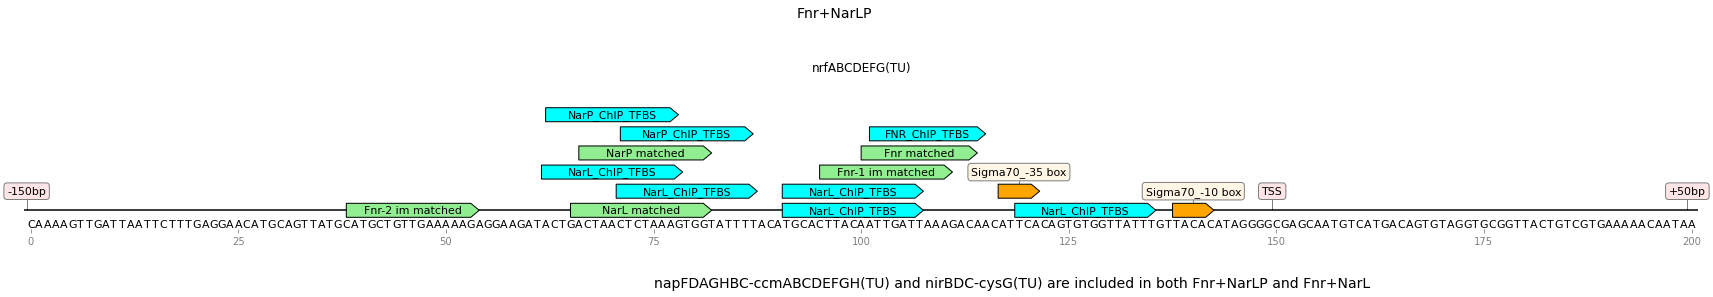

In [20]:
fig, axs = plt.subplots( len(Fnr_NarLP_seq_names), 1,figsize=(30,4), sharex=True  )
for i in range(len(Fnr_NarLP_seq_names)):
    Fnr_NarLP_records[i].plot(figure_width=5, ax = axs)
    Fnr_NarLP_records[i].plot_sequence(ax = axs)
    axs.set_title(Fnr_NarLP_seq_names[i]+"(TU)",y = 0.7 )
axs.text(75,-4,'napFDAGHBC-ccmABCDEFGH(TU) and nirBDC-cysG(TU) are included in both Fnr+NarLP and Fnr+NarL',fontsize=14)
fig.suptitle('Fnr+NarLP',y=0.9,fontsize=14)
fig.savefig('../../../thesis_plots/FnrNarLP_promoters.svg',dpi=150)

## Fnr-1

In [69]:
Fnr_1 = list(set(raw_data['ID'])&set(IM_genes['Fnr-1']) )
Fnr_1_tus = []
for gene_id in Fnr_1:
    temp = mg1655.gene_table[mg1655.gene_table.index==gene_id]
    left =  list( temp['left'])[0]
    right = list( temp['right'])[0]
    temp = mg1655.features_in_range(left,right)
    temp = temp[temp['type']=='tu']
    Fnr_1_tus.append( list(temp.index)[0] )
Fnr_1_tus = list( set(Fnr_1_tus))
print(Fnr_1_tus)

['ECK120026897', 'ECK120021227', 'ECK120009049', 'ECK120009345', 'ECK120027102', 'ECK120009459', 'ECK120020436', 'ECK120009239', 'ECK120009037', 'ECK120009216', 'ECK120009348', 'ECK120009084', 'ECK120008921', 'ECK120009496', 'ECK120009478', 'ECK120009564', 'ECK120027085']


In [74]:
Fnr_1_records = []
Fnr_1_names = []

feature_list = ['Fnr','Fnr-1 im','Fnr-2 im','NarL','NarP']
feature_width = {'Fnr':14,'Fnr-1 im':16,'Fnr-2 im':16,'NarL':17,'NarP':16}


N_UPSTREAM = 150
N_DOWNSTREAM = 50
    
for i in range(len(Fnr_1_tus)):
    features = [ GraphicFeature(start= N_UPSTREAM, end= N_UPSTREAM , strand=+1, color='red',label="TSS") ]
    tu_id = Fnr_1_tus[i]
    temp = mg1655.tu_table[mg1655.tu_table.index == tu_id ]
    tss = int(list(temp['tss'])[0])
    strand = list(temp['strand'])[0]
    tu_name = list(temp['name'])[0]
    tu_length = int( list(temp['right'])[0] - list(temp['left'])[0] + 1 )
    sub_raw_data = raw_data[ (raw_data['TU']==tu_name) & (raw_data['TU_length']==tu_length) ]
    if len(sub_raw_data['ID']) < 1:
        continue
    for f_name in feature_list:
        distToTSS = list(sub_raw_data[f_name+' distToTSS'])[0]
        if list(sub_raw_data[f_name+' upstreamTSS'])[0] == 1:
            mid = N_UPSTREAM - distToTSS 
        else:
            mid = N_UPSTREAM + distToTSS
        width =  feature_width[ f_name ]
        features.append( GraphicFeature(start= mid-width/2, end= mid+width/2,
                                        strand=+1, color='lightgreen',label=f_name+" matched") )
    if strand == 1:
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
        
    seq = seq_loc.extract( mg1655.sequence)
    if strand ==1:
        temp = mg1655.features_in_range(tss - N_UPSTREAM - 1, tss + N_DOWNSTREAM)
    else:
        temp = mg1655.features_in_range( tss - N_DOWNSTREAM - 1,  tss + N_UPSTREAM )
    #op_temp = temp[temp['type']=='operon']
    #op_name = list(op_temp['name'])[0]
    if 'tfbs' in list (temp['type']):
        temp = temp[temp['type']=='tfbs']
        temp = temp[(temp['tf']=='FNR')|(temp['tf']=='NarL')|(temp['tf']=='NarP')]
        for j in range(len(temp['left'])):
            tfbs_left = list(temp['left'])[j]
            tfbs_right = list(temp['right'])[j]
            distTSS =  (tfbs_left+tfbs_right)/2 - tss
            mid = N_UPSTREAM + distTSS
            if list(temp['tf'])[j] == 'FNR':
                width = feature_width['Fnr']
            else:
                width = feature_width[ list(temp['tf'])[j] ]
            if mid >0 and mid < 200:
                features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =list(temp['tf'])[j]+"_ChIP_TFBS" ) )
        
    Fnr_1_records.append( GraphicRecord(sequence_length= N_UPSTREAM+N_DOWNSTREAM+1 , sequence= seq , features=features ) )
    Fnr_1_names.append( tu_name )

Text(0.5, 0.9, 'Fnr-1')

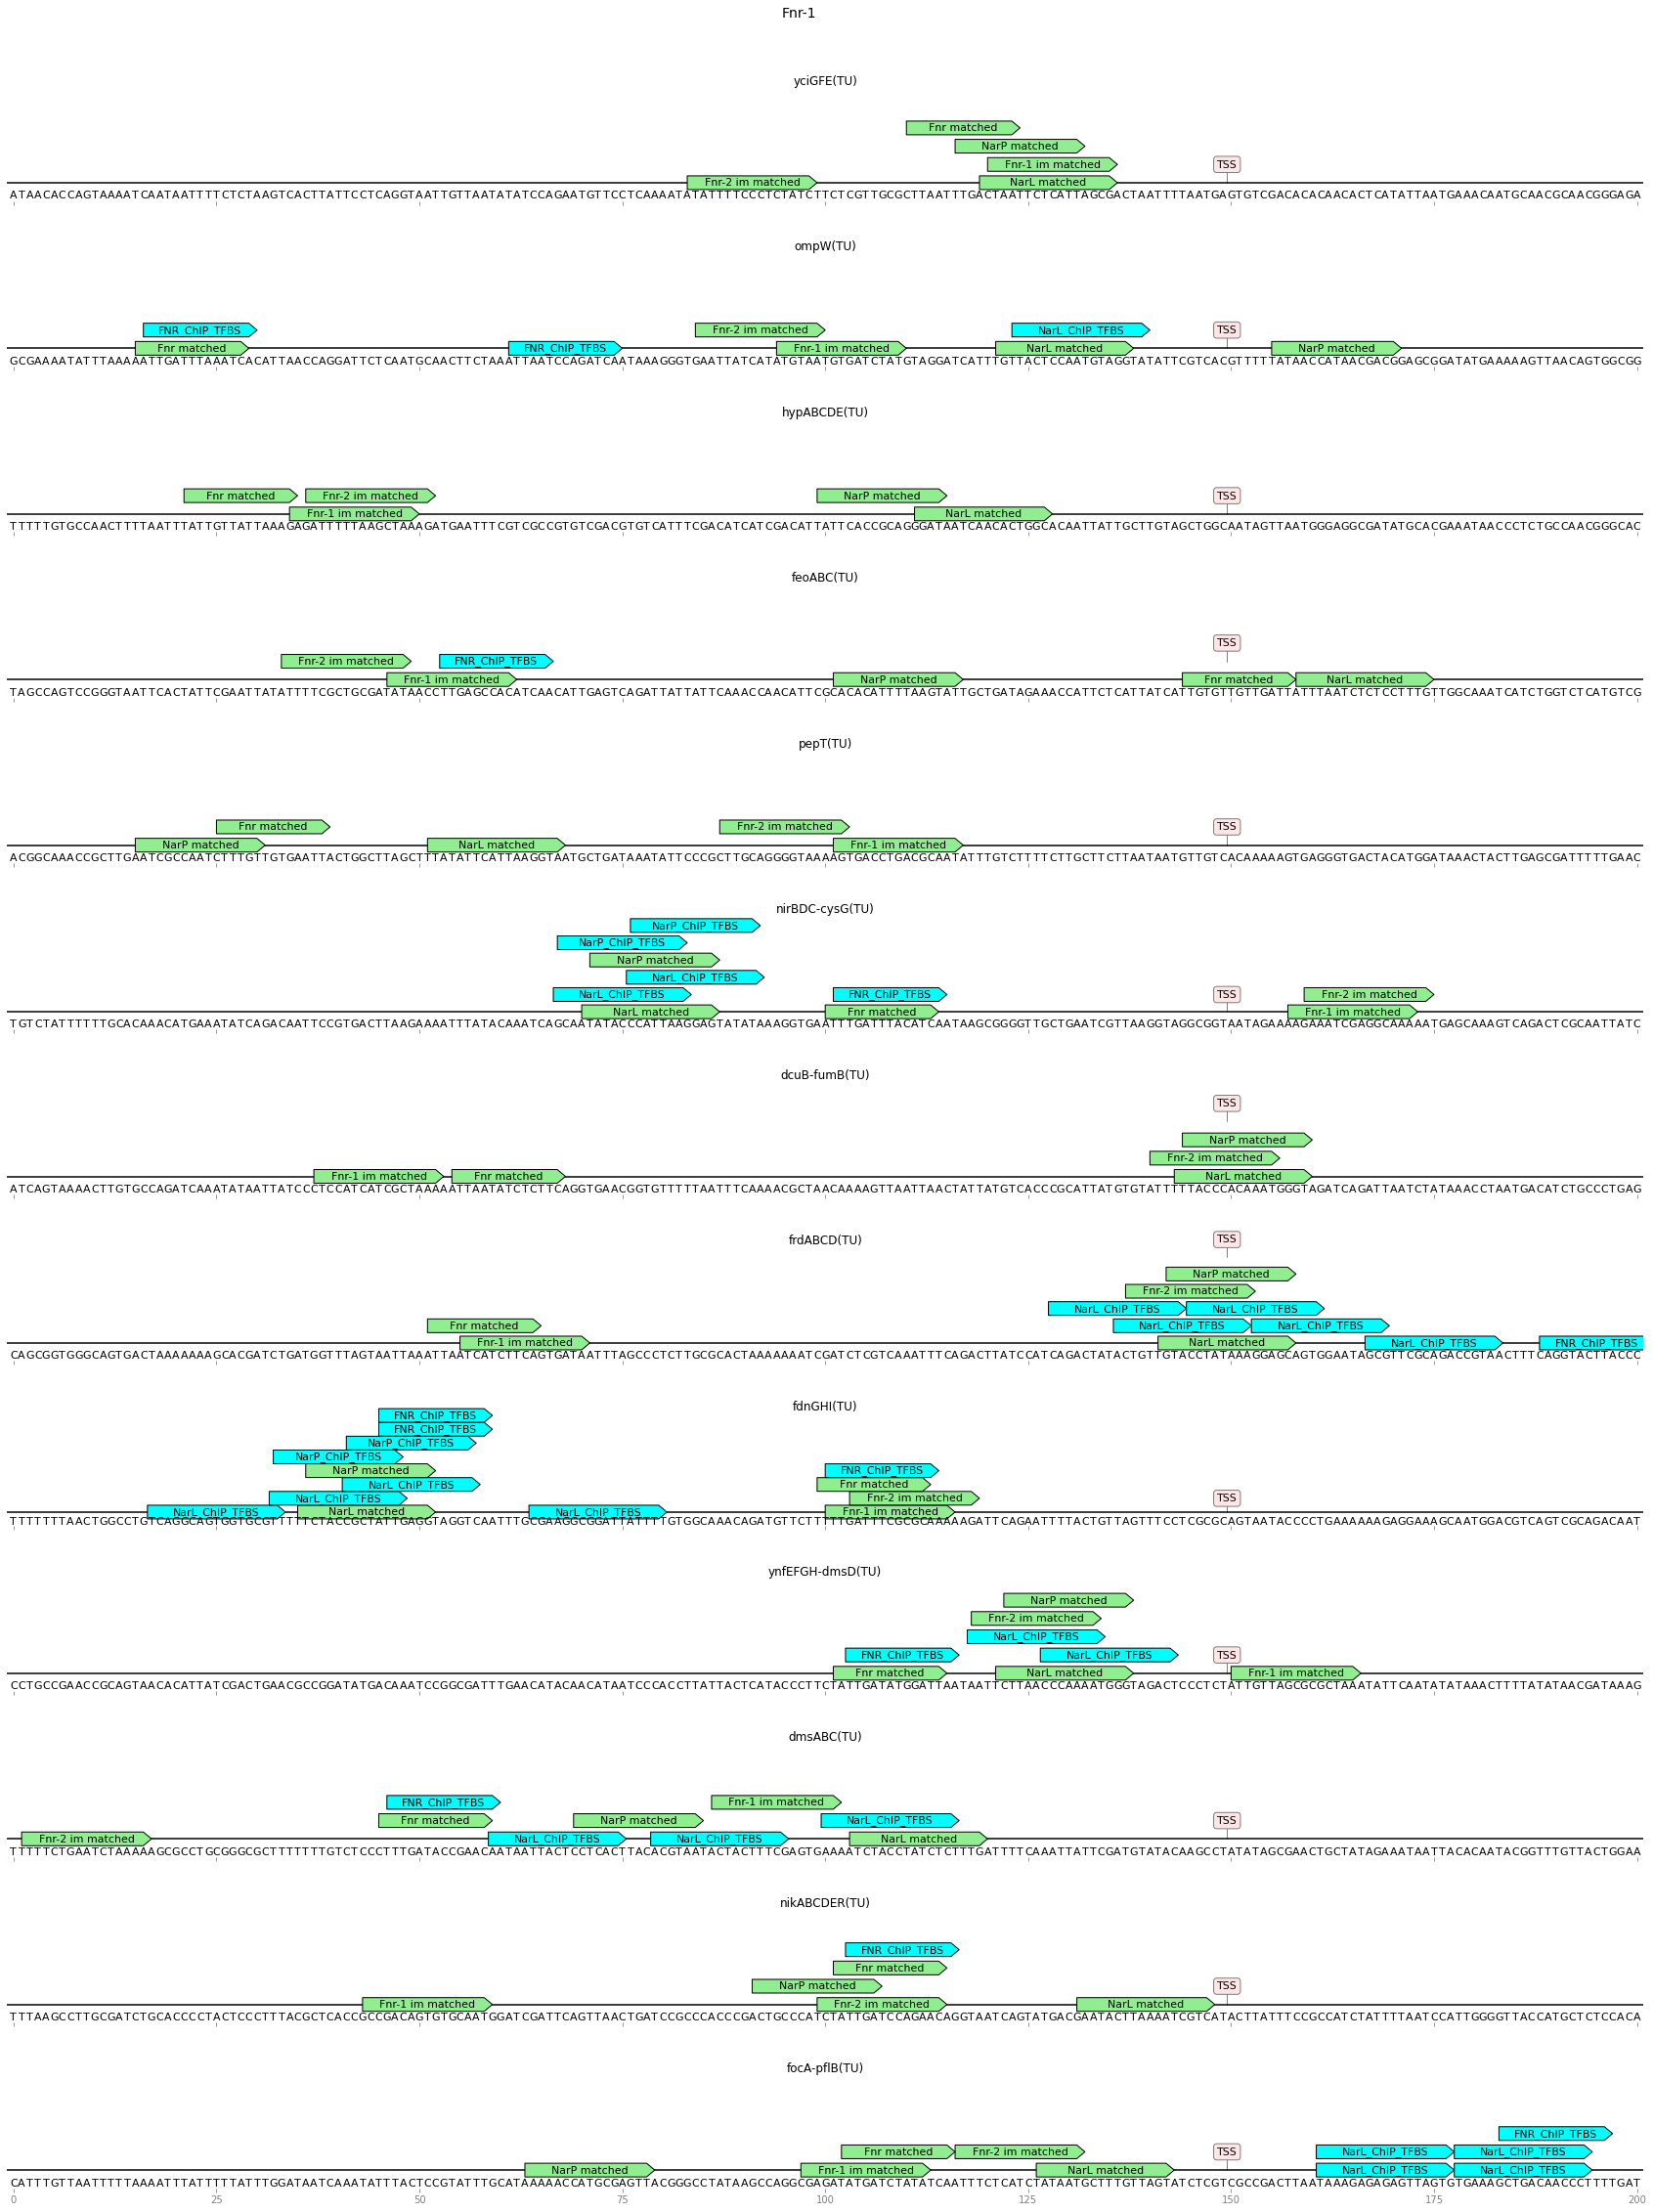

In [76]:
fig, axs = plt.subplots( len(Fnr_1_names), 1,figsize=(30,40), sharex=True  )
for i in range(len(Fnr_1_names)):
    Fnr_1_records[i].plot(figure_width=5, ax = axs[i])
    Fnr_1_records[i].plot_sequence(ax = axs[i])
    axs[i].set_title(Fnr_1_names[i]+"(TU)",y = 0.8 )
fig.suptitle('Fnr-1',y=0.9,fontsize=14)

## Fnr-2

In [41]:
Fnr_2 = list(set(raw_data['ID'])&set(IM_genes['Fnr-2']) )
Fnr_2_tus = []
for gene_id in Fnr_2:
    temp = mg1655.gene_table[mg1655.gene_table.index==gene_id]
    left =  list( temp['left'])[0]
    right = list( temp['right'])[0]
    temp = mg1655.features_in_range(left,right)
    temp = temp[temp['type']=='tu']
    Fnr_2_tus.append( list(temp.index)[0] )
Fnr_2_tus = list( set(Fnr_2_tus))
print(Fnr_2_tus)

['ECK120009111', 'ECK120009223', 'ECK120008925', 'ECK120027707', 'ECK120008977', 'ECK120027243', 'ECK120009037', 'ECK120021180', 'ECK120009268', 'ECK120010968', 'ECK120008921', 'ECK120021008', 'ECK120009181', 'ECK120026299', 'ECK120009325', 'ECK120021101', 'ECK120009478', 'ECK120026942', 'ECK120027286', 'ECK120010895', 'ECK120027557', 'ECK120011166', 'ECK120009215', 'ECK120009216', 'ECK120009237', 'ECK120009345', 'ECK120027810', 'ECK120009459', 'ECK120020476', 'ECK120027060', 'ECK120009493', 'ECK120027047', 'ECK120009084', 'ECK120026819']


In [42]:
len(Fnr_2_tus)

34

In [49]:
Fnr_2_records = []
Fnr_2_names = []

feature_list = ['Fnr','Fnr-1 im','Fnr-2 im','NarL','ArcA']
feature_width = {'Fnr':14,'Fnr-1 im':16,'Fnr-2 im':16,'NarL':17,'ArcA':17}


N_UPSTREAM = 150
N_DOWNSTREAM = 50
    
for i in range(9):
    features = [ GraphicFeature(start= N_UPSTREAM, end= N_UPSTREAM , strand=+1, color='red',label="TSS") ]
    tu_id = Fnr_2_tus[i]
    temp = mg1655.tu_table[mg1655.tu_table.index == tu_id ]
    tss = int(list(temp['tss'])[0])
    strand = list(temp['strand'])[0]
    tu_name = list(temp['name'])[0]
    tu_length = int( list(temp['right'])[0] - list(temp['left'])[0] + 1 )
    sub_raw_data = raw_data[ (raw_data['TU']==tu_name) & (raw_data['TU_length']==tu_length) ]
    if len(sub_raw_data['ID']) < 1:
        continue
    for f_name in feature_list:
        distToTSS = list(sub_raw_data[f_name+' distToTSS'])[0]
        if list(sub_raw_data[f_name+' upstreamTSS'])[0] == 1:
            mid = N_UPSTREAM - distToTSS 
        else:
            mid = N_UPSTREAM + distToTSS
        width =  feature_width[ f_name ]
        features.append( GraphicFeature(start= mid-width/2, end= mid+width/2,
                                        strand=+1, color='lightgreen',label=f_name+" matched") )
    if strand == 1:
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
        
    seq = seq_loc.extract( mg1655.sequence)
    if strand ==1:
        temp = mg1655.features_in_range(tss - N_UPSTREAM - 1, tss + N_DOWNSTREAM)
    else:
        temp = mg1655.features_in_range( tss - N_DOWNSTREAM - 1,  tss + N_UPSTREAM )
    #op_temp = temp[temp['type']=='operon']
    #op_name = list(op_temp['name'])[0]
    if 'tfbs' in list (temp['type']):
        temp = temp[temp['type']=='tfbs']
        temp = temp[(temp['tf']=='FNR')|(temp['tf']=='NarL')|(temp['tf']=='ArcA')]
        for j in range(len(temp['left'])):
            tfbs_left = list(temp['left'])[j]
            tfbs_right = list(temp['right'])[j]
            distTSS =  (tfbs_left+tfbs_right)/2 - tss
            mid = N_UPSTREAM + distTSS
            if list(temp['tf'])[j] == 'FNR':
                width = feature_width['Fnr']
            else:
                width = feature_width[ list(temp['tf'])[j] ]
            if mid >0 and mid < 200:
                features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color='cyan',label =list(temp['tf'])[j]+"_ChIP_TFBS" ) )
        
    Fnr_2_records.append( GraphicRecord(sequence_length= N_UPSTREAM+N_DOWNSTREAM+1 , sequence= seq , features=features ) )
    Fnr_2_names.append( tu_name )

Text(0.5, 0.9, 'Fnr-2')

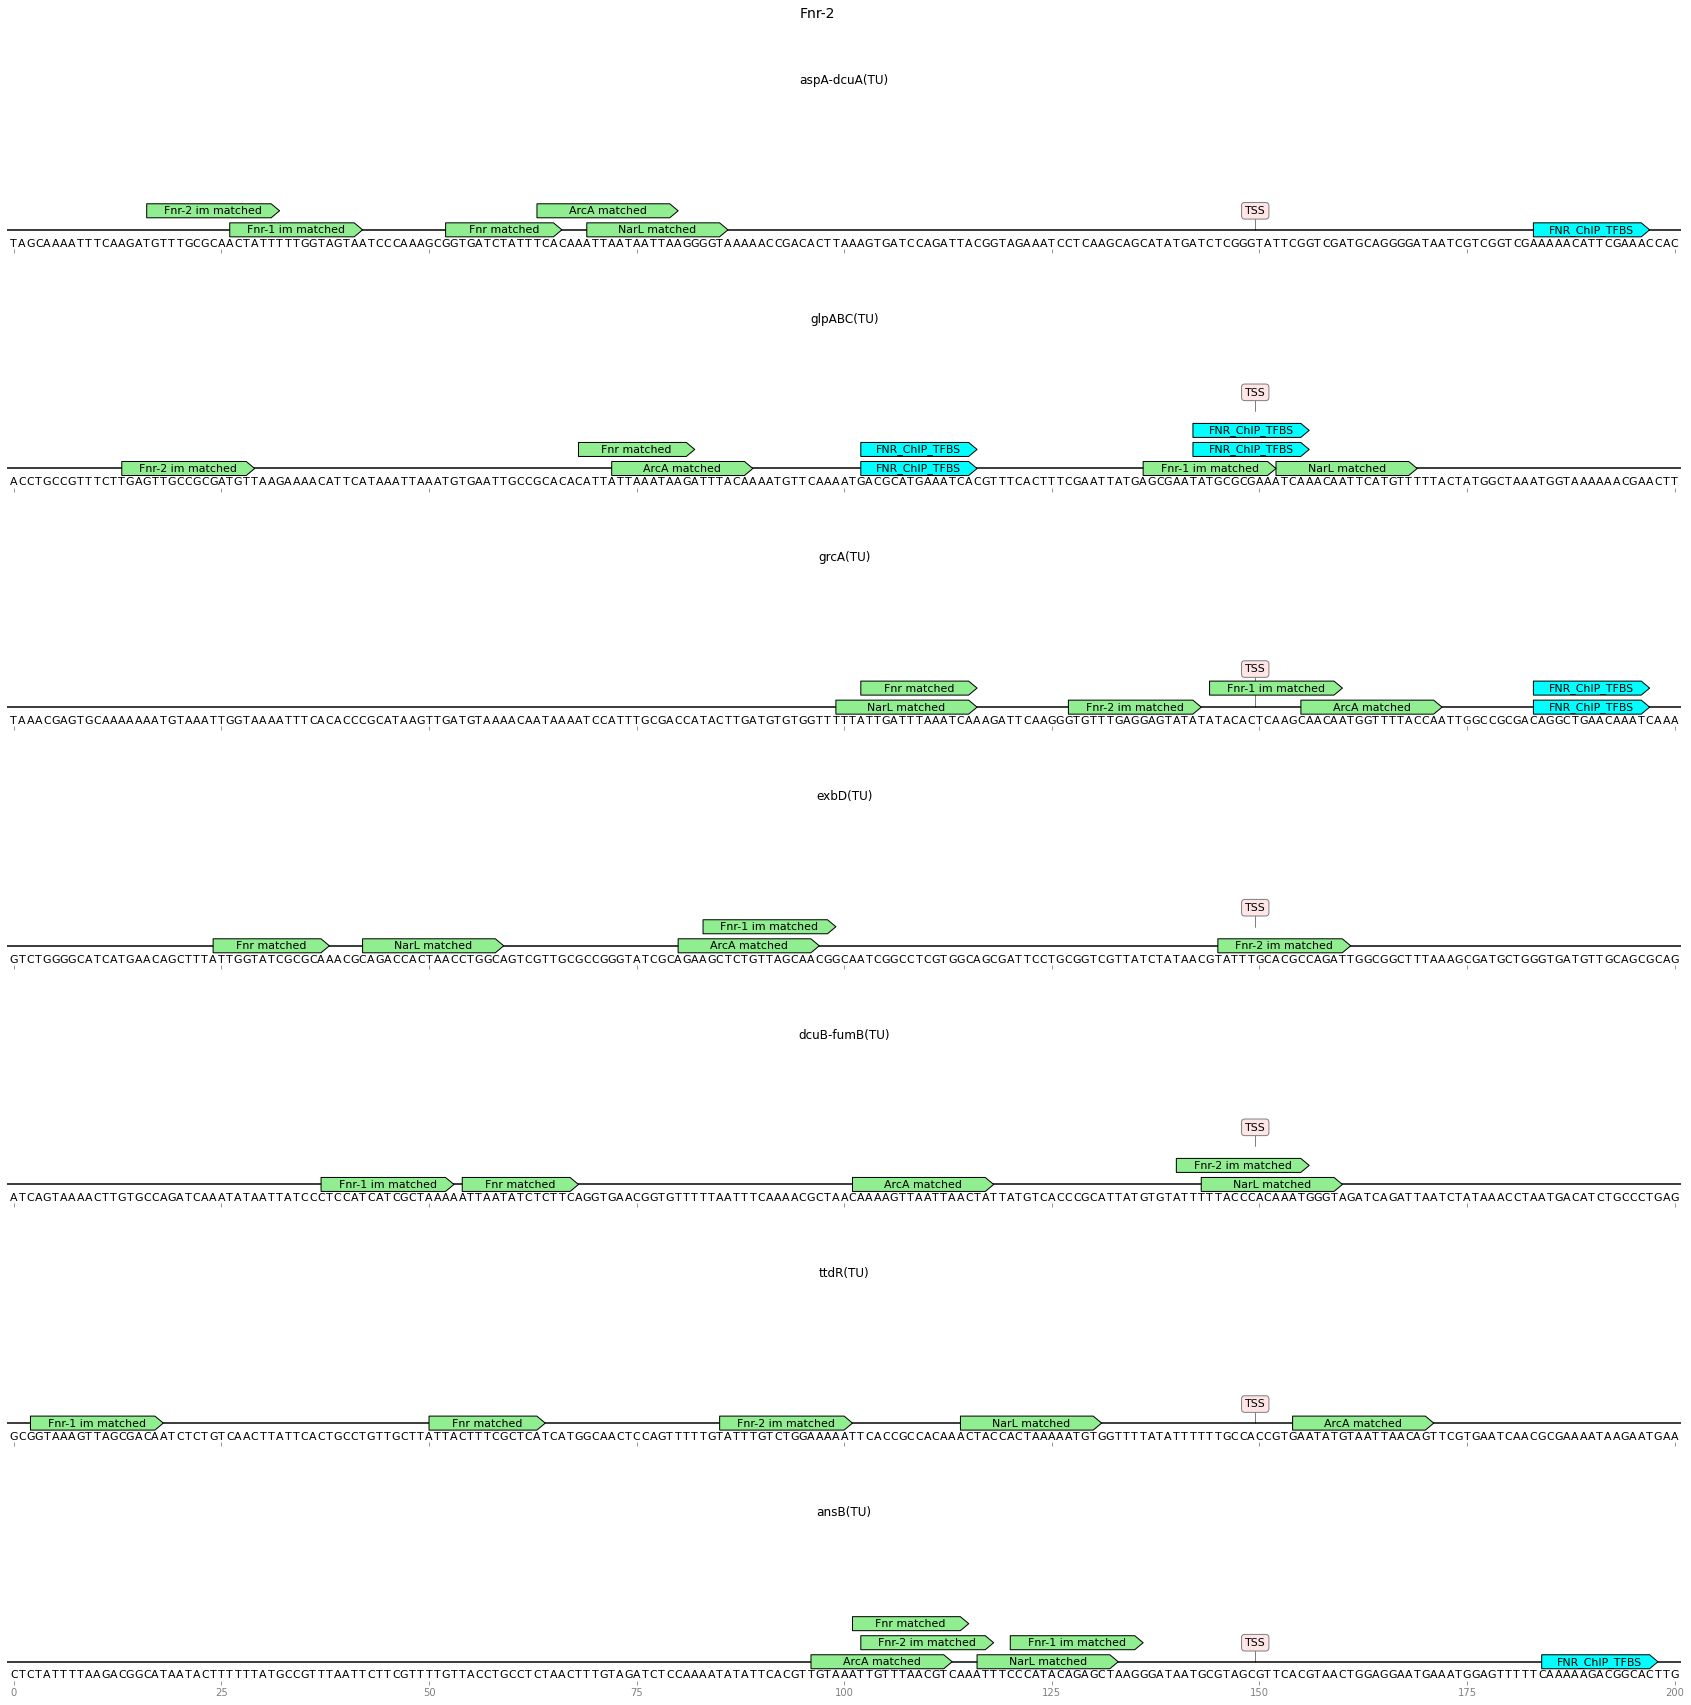

In [50]:
fig, axs = plt.subplots( len(Fnr_2_names), 1,figsize=(30,30), sharex=True  )
for i in range(len(Fnr_2_names)):
    Fnr_2_records[i].plot(figure_width=5, ax = axs[i])
    Fnr_2_records[i].plot_sequence(ax = axs[i])
    axs[i].set_title(Fnr_2_names[i]+"(TU)",y = 0.8 )
fig.suptitle('Fnr-2',y=0.9,fontsize=14)

## look into TFBS location

In [6]:
fnr_tfbs = mg1655.tfbs_table[  mg1655.tfbs_table['tf']=='FNR']
keep_inds = []
for i in range( len(fnr_tfbs['left']) ):
    if fnr_tfbs['left'][i] != 0 and fnr_tfbs['right'][i] != 0:
        keep_inds.append(i)
fnr_tfbs = fnr_tfbs.iloc[keep_inds]
fnr_tfbs= fnr_tfbs.reset_index()
fnr_tfbs

,locus_tag,left,right,mode,final_state,tf,strand
0,ECK120011231,816781,816794,activator,FNR,FNR,NaN
1,ECK120011246,2716610,2716623,repressor,FNR,FNR,NaN
2,ECK120011248,2716557,2716570,dual,FNR,FNR,NaN
3,ECK120011248,2716557,2716570,dual,FNR,FNR,NaN
4,ECK120011366,656110,656123,activator,FNR,FNR,NaN
...,...,...,...,...,...,...,...
100,ECK125141262,652022,652035,repressor,FNR,FNR,NaN
101,ECK125141262,652022,652035,repressor,FNR,FNR,NaN
102,ECK125230731,1313858,1313871,repressor,FNR,FNR,NaN
103,ECK125258349,3931323,3931336,activator,FNR,FNR,NaN


In [7]:
tu_ids = []
tss_list = []
op_name_list = []
op_id_list = []
strand_list = []
for i in range( len(fnr_tfbs['left']) ):
    tfbs_left = fnr_tfbs['left'][i]
    tfbs_right = fnr_tfbs['right'][i]
    temp = mg1655.features_in_range( tfbs_left, tfbs_right  )
    temp = temp[temp['type']=='operon']
    strand_list.append( list(temp['strand'])[0]  )
    op_name_list.append( list(temp['name'])[0] )
    op_id_list.append( list(temp.index)[0] )
    
    op_left = list(temp['left'])[0]
    op_right = list(temp['right'])[0]
    temp = mg1655.features_in_range( op_left, op_right  )
    temp = temp[temp['type']=='tu']
    distance = []
    for tss in temp['tss']:
        dist = tss - (tfbs_left + tfbs_right)/2
        distance.append( abs(dist ) )
        
    min_index = distance.index( min(distance) )
    tu_ids.append(  list(temp.index)[min_index] )
    tss_list.append(  list(temp['tss'])[min_index] )
    
fnr_tfbs['tu_id'] = tu_ids
fnr_tfbs['strand'] = strand_list
fnr_tfbs['tss'] = tss_list
fnr_tfbs['operon_id'] = op_id_list
fnr_tfbs['operon_name'] = op_name_list
fnr_tfbs = fnr_tfbs.dropna()
fnr_tfbs = fnr_tfbs.reset_index()
fnr_tfbs = fnr_tfbs.drop(columns=['index'])

Text(0.5, 1.0, 'FNR')

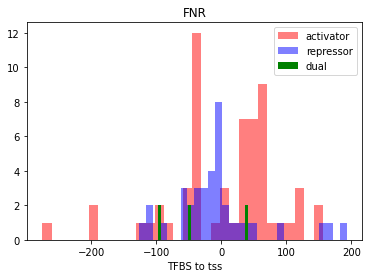

In [8]:
tssTotfbs = {'A':[],'R':[],'D':[]}
for i in range( len(fnr_tfbs['left']) ):
    tfbs_left = fnr_tfbs['left'][i]
    tfbs_right = fnr_tfbs['right'][i]
    mid = (tfbs_left + tfbs_right)/2
    tss = fnr_tfbs['tss'][i]
    if fnr_tfbs['mode'][i] == 'activator':
        tssTotfbs['A'].append(  mid - tss )
    elif fnr_tfbs['mode'][i] == 'repressor':
        tssTotfbs['R'].append(  mid - tss )
    else:
        tssTotfbs['D'].append(  mid - tss )
        
plt.hist( tssTotfbs['A'],bins=30,alpha=0.5, color='red', label='activator')
plt.hist( tssTotfbs['R'],bins=30,alpha=0.5, color = 'blue',label = 'repressor')
plt.hist( tssTotfbs['D'],bins=30,alpha=1, color = 'green',label = 'dual')
plt.legend(loc='upper right')
plt.xlabel('TFBS to tss')
plt.title('FNR')
#plt.xlim([-230,200])

(array([59.,  0.,  0.,  0.,  0., 37.,  0.,  0.,  0.,  6.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

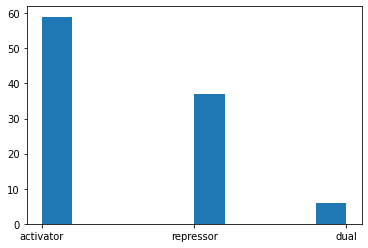

In [9]:
plt.hist(fnr_tfbs['mode'])

In [10]:
TFBS_fnr = pd.read_csv('../BindingSite.csv')
TFBS_fnr = TFBS_fnr[ TFBS_fnr['TF name']=='Fnr']
TFBS_fnr = TFBS_fnr.rename(columns={'TF name': 'tf', 'TF-bs left end': 'left','TF-bs right end':'right',
                                   'strand':'strand','Evidence confidence level':'confidence'})
TFBS_fnr = TFBS_fnr.reset_index()
TFBS_fnr = TFBS_fnr.drop(columns=['index'])
TFBS_fnr.head()

,tf,left,right,strand,confidence
0,Fnr,34156,34169,forward,Weak
1,Fnr,42072,42085,reverse,Weak
2,Fnr,42121,42134,forward,Weak
3,Fnr,42121,42134,reverse,Weak
4,Fnr,121977,121990,forward,Weak


In [11]:
evid_level=[]
for i in range(len(fnr_tfbs['left']) ):
    temp_left = list(fnr_tfbs['left'])[i]
    sub = TFBS_fnr[TFBS_fnr['left']==temp_left]
    if len(sub['confidence']) < 1:
        evid_level.append('Weak')
    else:
        evid_level.append( list(sub['confidence'])[0] ) 
fnr_tfbs['confidence'] = evid_level

Text(0.5, 1.0, 'FNR(strong)')

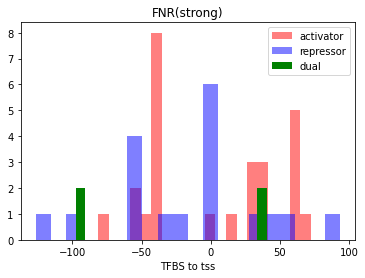

In [12]:
tssTotfbs = {'A':[],'R':[],'D':[]}
for i in range( len(fnr_tfbs['left']) ):
    tfbs_left = fnr_tfbs['left'][i]
    tfbs_right = fnr_tfbs['right'][i]
    mid = (tfbs_left + tfbs_right)/2
    tss = fnr_tfbs['tss'][i]
    if fnr_tfbs['confidence'][i] == 'Strong':
        if fnr_tfbs['mode'][i] == 'activator':
            tssTotfbs['A'].append(  mid - tss )
        elif fnr_tfbs['mode'][i] == 'repressor':
            tssTotfbs['R'].append(  mid - tss )
        else:
            tssTotfbs['D'].append(  mid - tss )
        
plt.hist( tssTotfbs['A'],bins=20,alpha=0.5, color='red', label='activator')
plt.hist( tssTotfbs['R'],bins=20,alpha=0.5, color = 'blue',label = 'repressor')
plt.hist( tssTotfbs['D'],bins=20,alpha=1, color = 'green',label = 'dual')
plt.legend(loc='upper right')
plt.xlabel('TFBS to tss')
plt.title('FNR(strong)')

Text(0.5, 1.0, 'FNR')

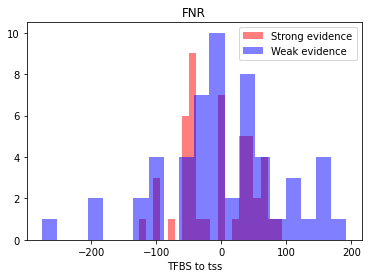

In [14]:
strong_fnr = []
weak_fnr = []
for i in range( len(fnr_tfbs['left']) ):
    tfbs_left = fnr_tfbs['left'][i]
    tfbs_right = fnr_tfbs['right'][i]
    mid = (tfbs_left + tfbs_right)/2
    tss = fnr_tfbs['tss'][i]
    if fnr_tfbs['confidence'][i] == 'Strong':
        strong_fnr.append( mid - tss )
    else:
        weak_fnr.append(mid - tss)
        
plt.hist( strong_fnr,bins=20,alpha=0.5, color='red', label='Strong evidence')
plt.hist( weak_fnr,bins=20,alpha=0.5, color = 'blue',label = 'Weak evidence')
plt.legend(loc='upper right')
plt.xlabel('TFBS to tss')
plt.title('FNR')   

In [15]:
N_upstream = 100
N_downstream = 100
fnr_score = []
fnr_dist = []
for i in range(len(fnr_tfbs['tss'])):
    tss = int( list(fnr_tfbs['tss'])[i] )
    strand = int( list(fnr_tfbs['strand'])[i] )
    result = motif_match_noshape( tss, strand,N_upstream, N_downstream,mg1655,pwm_db, 'Fnr', False )
    fnr_score.append( result['Fnr score'])
    if result['Fnr upstreamTSS'] == 1:
        fnr_dist.append( - result['Fnr distToTSS'] )
    else:
        fnr_dist.append( result['Fnr distToTSS'] )

In [16]:
fnr_tfbs['Fnr score'] = fnr_score
fnr_tfbs['distToTSS_matched'] = fnr_dist

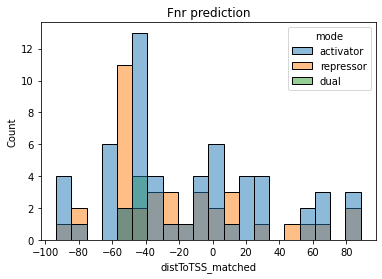

In [25]:
sns.histplot(fnr_tfbs,x='distToTSS_matched',hue='mode',bins = 20)
plt.title('Fnr prediction')
plt.xticks(np.arange(-100,100,20));